This script conducts all statistical analyses and generates all figures included in the paper.

# Functions and Global Variables
This module sets up functions that will be called by several sections to make sure identical plots. 

In [2]:
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import PathPatch
from matplotlib.path import Path

def fill_between_gradient_imshow(ax, x, y1, y2, color_start, color_end, wlen, alpha=0.3, resolution=300):
    x = np.asarray(x)
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)
    # y1 = pd.Series(y1).interpolate(method='linear', limit_direction='both').to_numpy()
    # y2 = pd.Series(y2).interpolate(method='linear', limit_direction='both').to_numpy()

    valid = ~np.isnan(x) & ~np.isnan(y1) & ~np.isnan(y2)
    x, y1, y2 = x[valid], y1[valid], y2[valid]
    if len(x) < 2:
        return

    sort_idx = np.argsort(x)
    x, y1, y2 = x[sort_idx], y1[sort_idx], y2[sort_idx]

    cmap = LinearSegmentedColormap.from_list("grad_fill", [color_start, color_end])
    xx = np.linspace(x.min(), x.max(), resolution)
    yy = np.linspace(min(y1.min(), y2.min()), max(y1.max(), y2.max()), resolution)

    # Build horizontal gradient weights: flat on ends, transition between -wlen/2 to wlen/2
    weights = np.zeros_like(xx, dtype=float)
    mask_grad = (xx >= - wlen/2) & (xx <= wlen/2)
    weights[xx > wlen/2] = 1.0
    weights[mask_grad] = (xx[mask_grad] + wlen/2) / wlen

    gradient = np.repeat(weights.reshape(1, -1), resolution, axis=0)

    im = ax.imshow(
        gradient, aspect='auto', extent=[x.min(), x.max(), yy.min(), yy.max()],
        origin='lower', cmap=cmap, alpha=alpha, interpolation='bicubic', zorder=1
    )

    # Create clip path
    verts = np.column_stack([x, y1])
    verts = np.concatenate([verts, np.column_stack([x[::-1], y2[::-1]])])
    path = Path(verts)
    patch = PathPatch(path, facecolor='none', edgecolor='none', zorder=2)
    ax.add_patch(patch)
    im.set_clip_path(patch)
    ax.autoscale_view()
    

def plot_gradient_line(ax, x, y, color_start, color_end, wlen, linewidth=1.5, zorder=3, linestyle='-'):
    x = np.asarray(x)
    y = np.asarray(y)
    # y = pd.Series(y).interpolate(method='linear', limit_direction='both').to_numpy()

    valid = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[valid], y[valid]

    if len(x) < 2:
        return

    if linestyle != '-':
        # fallback to standard plot for dashed or dotted styles (no gradient support)
        ax.plot(x, y, color=color_start, linestyle=linestyle, linewidth=linewidth, zorder=zorder)
    else:
        sort_idx = np.argsort(x)
        x, y = x[sort_idx], y[sort_idx]

        # Define gradient weights
        weights = np.zeros_like(x, dtype=float)
        mask_grad = (x >= -wlen/2) & (x <= wlen/2)
        weights[x > wlen/2] = 1.0
        weights[mask_grad] = (x[mask_grad] + wlen/2) / wlen  # Normalize [-wlen/2, wlen/2]

        cmap = LinearSegmentedColormap.from_list("grad", [color_start, color_end])
        colors = cmap(weights)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, colors=colors[:-1], linewidth=linewidth, zorder=zorder)
        ax.add_collection(lc)

    ax.autoscale_view()

# Rename features for readability
feature_rename = {
    "norm_fix_word_num": "Fixation Rate",
    "norm_in_word_reg": "In-Word Regression",
    "norm_out_word_reg": "Out-Of-Word Regression",
    "pupil_slope": "Pupil Change Rate",
    "norm_pupil": "Pupil Size",
    "fix_dispersion": "Fixation Dispersion",
    "zscored_zipf_fixdur_corr": "Word Frequency-Fixation Correlation",
    "weighted_vergence": "Vergence"
}

features = [
        "norm_fix_word_num", "norm_in_word_reg", "norm_out_word_reg",
        "zscored_zipf_fixdur_corr", 'fix_dispersion', 
        'weighted_vergence', "pupil_slope", "norm_pupil"
    ]


# Demographic info

In [9]:
import pandas as pd
import os

# Load the Excel file
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = "demo_info.xlsx"  # Update path if needed
df = pd.read_excel(os.path.join(path, file_name))

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Convert subject IDs to numeric
subject_ids = ['s10110', 's10014', 's10052', 's10059', 's10073', 's10081', 's10084', 's10085',
               's10089', 's10094', 's10100', 's10103', 's10111', 's10115', 's10117', 's10121',
               's10125', 's10138', 's10139', 's10141', 's10144', 's10145', 's10148', 's10153',
               's10156', 's10158', 's10159', 's10160', 's10165', 's10173', 's10176', 's10177',
               's10178', 's10180', 's10181', 's10183', 's10185', 's10186', 's10188', 's10192',
               's10195', 's10196', 's10197', 's10200', 's10202']
subject_nums = [int(s[1:]) for s in subject_ids]

# Filter by participant ID
df_filtered = df[df['participant_id'].isin(subject_nums)].copy()

# Age: ensure numeric and compute stats
df_filtered['age'] = pd.to_numeric(df_filtered['age'], errors='coerce')
age_min = df_filtered['age'].min()
age_max = df_filtered['age'].max()
age_median = df_filtered['age'].median()
age_mean = df_filtered['age'].mean()

# Gender: clean and count
df_filtered['gender_clean'] = df_filtered['gender'].str.strip().str.lower()
df_filtered['gender_clean'] = df_filtered['gender_clean'].replace({
    'female': 'female',
    'male': 'male',
    'nonbinary': 'non-binary',
    'non-binary': 'non-binary',
    'gender-nonconforming': 'non-binary',
    'transgender male': 'non-binary'
})
gender_counts = df_filtered['gender_clean'].value_counts()

# Handedness: clean and count
df_filtered['handness_clean'] = df_filtered['handness'].str.strip().str.lower()
df_filtered['handness_clean'] = df_filtered['handness_clean'].replace({
    'right': 'right',
    'left': 'left',
    'left, but used right-handed setup': 'left',
    'left-handed setup': 'left',
    'left, but used right-handed setup for mouse and keyboard': 'left',
    'ambidextrous (left-hand dominant)': 'left'
})
handness_counts = df_filtered['handness_clean'].value_counts()

# Print results
print(f"Age range: {age_min} - {age_max}")
print(f"Median age: {age_median}")
print(f"Mean age: {age_mean:.2f}")
print("\nGender distribution:")
print(gender_counts)
print("\nHandedness distribution:")
print(handness_counts)

Age range: 18 - 64
Median age: 20.0
Mean age: 22.49

Gender distribution:
female        31
male           9
non-binary     5
Name: gender_clean, dtype: int64

Handedness distribution:
right    38
left      7
Name: handness_clean, dtype: int64


# Comprehension report (trial level)

In [8]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_1samp
# load psychopy responses files
# root path
path = r"/Volumes/GBLDrive/MindlessReading/Data"
df = pd.read_csv(os.path.join(path, 'Files', 'trial_level_data.csv'))
trial_count = len(df)

# ===========================================================================================
# comprehension questions
acc_avg = df['accuracy'].mean()
msg = f'Participants answered a mean of {acc_avg*100}% of comprehension questions correctly.'
print(msg)
# ANOVA Test
# Run the one-way ANOVA
model = ols('accuracy ~ C(reading)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA RESULTS (Unfiltered Acc)")
print(anova_table)

# run a Tukey’s HSD post-hoc test
tukey_result = pairwise_tukeyhsd(endog=df['accuracy'], groups=df['reading'], alpha=0.05)
print('\n')
print(tukey_result)
print('\n')


# ===========================================================================================
# comprehension question accuracy after filtering out "I don't know"
acc_avg = df['filtered_accuracy'].mean()
msg = f'Participants answered a mean of {acc_avg*100}% of comprehension questions correctly.'
print(msg)
# ANOVA Test
# Run the one-way ANOVA
model = ols('filtered_accuracy ~ C(reading)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA RESULTS (Filtered Acc)")
print(anova_table)

# run a Tukey’s HSD post-hoc test
tukey_result = pairwise_tukeyhsd(endog=df['filtered_accuracy'], groups=df['reading'], alpha=0.05)
print('\n')
print(tukey_result)
print('\n')


# ===========================================================================================
# one sample t-test comparing acc to chance level
chance_level = 1 / 4

# Group by story and run one-sample t-test for each
results = []
for story, group in df.groupby('reading'):
    acc = group['filtered_accuracy'].dropna()
    # acc = group['accuracy'].dropna()
    if len(acc) > 1:  # Ensure enough data points
        t_stat, p_val = ttest_1samp(acc, chance_level)
        results.append({
            'story': story,
            'n_participants': len(acc),
            'mean_accuracy': acc.mean(),
            't_stat': t_stat,
            'p_value': p_val
        })

# Convert to DataFrame for easy viewing
story_test_df = pd.DataFrame(results)

# Optional: Add significance flag
story_test_df['significant'] = story_test_df['p_value'] < 0.05
print('One Sample t-test')
print('===============================================================================')
print(story_test_df.sort_values('p_value'))
print('-------------------------------------------------------------------------------')
print('\n')


# ===========================================================================================
# understandability
m = np.sum(df['understand'] > 3)
msg = f'On {m}/{trial_count} ({m/trial_count * 100}%) of runs, participants agreed or strongly agreed that they could understand the text.'
print(msg)

# prior knowledge
n = np.sum(df['prior_knowledge'] > 3)
msg = f'On {n}/{trial_count} ({n/trial_count * 100}%) of runs, participants agreed or strongly agreed they had prior knowledge that helped them answer the comprehension questions.'
print(msg)



Participants answered a mean of 61.68888888888889% of comprehension questions correctly.
ANOVA RESULTS (Unfiltered Acc)
              sum_sq     df         F    PR(>F)
C(reading)  0.898489    4.0  6.573726  0.000051
Residual    7.517333  220.0       NaN       NaN


              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
      group1              group2         meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------------------
  History of Film                  Pluto   0.0244 0.9706 -0.0827  0.1316  False
  History of Film      Prisoners Dilemma  -0.1089 0.0445 -0.2161 -0.0017   True
  History of Film        Serena Williams   0.0556 0.6118 -0.0516  0.1627  False
  History of Film The Voynich Manuscript   0.0689 0.3951 -0.0383  0.1761  False
            Pluto      Prisoners Dilemma  -0.1333 0.0066 -0.2405 -0.0261   True
            Pluto        Serena Williams   0.0311 0.9309 -0.0761  0.1383  False
            Pl

# Reading time hist

== 45 Subjects ==
['s10110' 's10014' 's10052' 's10059' 's10073' 's10081' 's10084' 's10085'
 's10089' 's10094' 's10100' 's10103' 's10111' 's10115' 's10117' 's10121'
 's10125' 's10138' 's10139' 's10141' 's10144' 's10145' 's10148' 's10153'
 's10156' 's10158' 's10159' 's10160' 's10165' 's10173' 's10176' 's10177'
 's10178' 's10180' 's10181' 's10183' 's10185' 's10186' 's10188' 's10192'
 's10195' 's10196' 's10197' 's10200' 's10202']

== Page Numbers ==
2250  reading pages
1046  mind-wandering episodes  0.4648888888888889

== Overall Reading Time ==
Mean: 58.913284053156154
Median: 57.6309999999994
Std Dev: 15.363162635569548

== Time Before MW Onset ==
Mean: 22.378713326941536
Median: 18.945999999999916
Std Dev: 17.553324152249324

== MW Duration ==
Mean: 7.793600191754534
Median: 5.9229999999997744
Std Dev: 7.2408095572535665


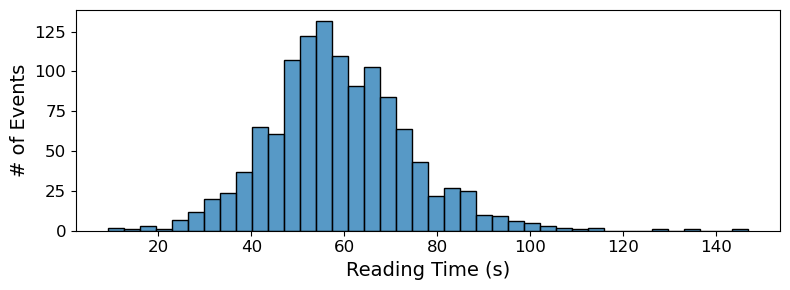

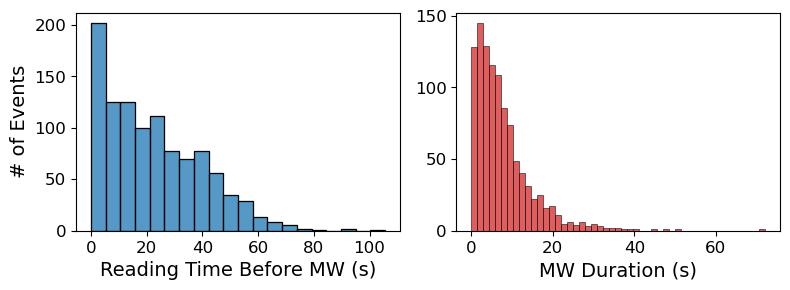

In [4]:
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# load eye feature file
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file = "reading_time_data.csv"
df = pd.read_csv(os.path.join(path, file))

path_to_save = r"/Volumes/GBLDrive/MindlessReading/Results/Behavior"

print(f"== {len(df['sub_id'].unique())} Subjects ==")
print(df['sub_id'].unique())

df_nr = df[~df['is_MWreported']]
df_mw = df[df['is_MWreported']]
print("\n== Page Numbers ==")
print(len(df), " reading pages")
print(len(df_mw), " mind-wandering episodes ", len(df_mw)/len(df))

# Stats for page_dur
print("\n== Overall Reading Time ==")
print("Mean:", df_nr['page_dur'].mean())
print("Median:", df_nr['page_dur'].median())
print("Std Dev:", df_nr['page_dur'].std())

# Stats for time before MW onset
print("\n== Time Before MW Onset ==")
print("Mean:", df_mw['page_start2onset'].mean())
print("Median:", df_mw['page_start2onset'].median())
print("Std Dev:", df_mw['page_start2onset'].std())

# Stats for MW duration
print("\n== MW Duration ==")
print("Mean:", df_mw['mw_dur'].mean())
print("Median:", df_mw['mw_dur'].median())
print("Std Dev:", df_mw['mw_dur'].std())

# sns.set(style="whitegrid")
plt.figure(figsize=(8, 3))
sns.histplot(data=df_nr, x='page_dur', color='tab:blue')
plt.ylabel("# of Events", fontsize=14)
plt.xlabel("Reading Time (s)", fontsize=14)
ax = plt.gca()  # get current axes
ax.tick_params(axis='both', labelsize=12)  # Make tick labels bigger
#ax.tick_params(axis='both', direction='in')  # 'in' makes ticks point inside
plt.tight_layout()
plt.savefig(os.path.join(path_to_save, 'reading_time_hist.png'))

df_mw = df[df['is_MWreported']]
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=False)

sns.histplot(data=df_mw, x='page_start2onset', color='tab:blue', ax=axs[0])
# axs[0].tick_params(axis='both', direction='in')  # 'in' makes ticks point inside
axs[0].set_xlabel('Reading Time Before MW (s)', fontsize=14)
axs[0].set_ylabel('# of Events', fontsize=14)
axs[0].tick_params(axis='both', labelsize=12)  # Make tick labels bigger

sns.histplot(data=df_mw, x='mw_dur', color='tab:red', ax=axs[1])
# axs[1].tick_params(axis='both', direction='in')  # 'in' makes ticks point inside
axs[1].set_xlabel('MW Duration (s)', fontsize=14)
axs[1].set_ylabel('')
axs[1].tick_params(axis='both', labelsize=12)  # Make tick labels bigger
plt.tight_layout()
plt.savefig(os.path.join(path_to_save, 'mw_duration_hist.png'))

# Eye-features line plot

## Line plot on the same figure

/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros.

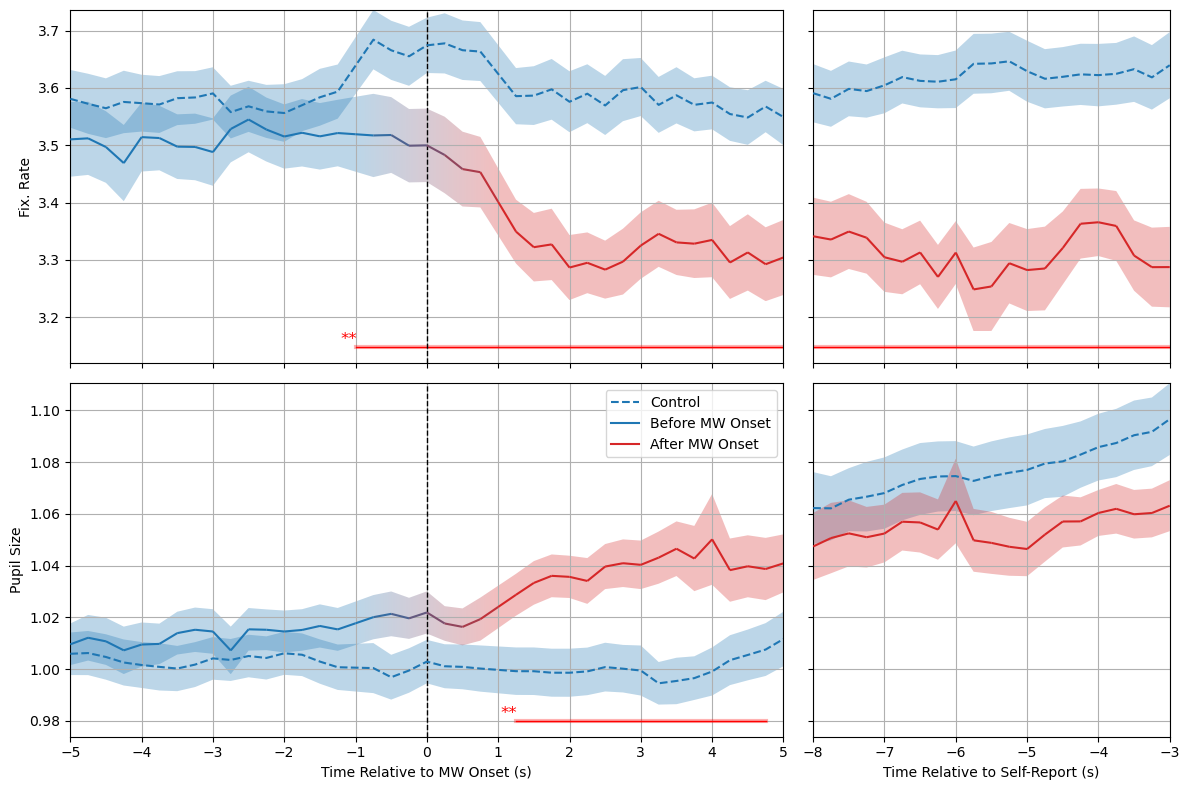

In [37]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

# GBLDriver path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
wlen = 2.0
# Slide Window (window duration 2 seconds)
file_name = f'group_features_slide{wlen}.csv'
# load group file
df = pd.read_csv(os.path.join(path, file_name))

# define the time offset (in seconds) to exclude
alpha = 2
mask = df['page_end']-df['win_end'] >= alpha
df = df[mask].copy()
# limit self-report to only MW discourse
mask = (df['label'] == 'self_report') & (df['win_start'] < df['mw_onset'])
df = df[~mask].copy()
df['relative_time'] = df['relative_time'].round(4)

# define features to plot
features = ['norm_fix_word_num', 'norm_pupil']

# mapping feature names to clean y-axis labels
y_labels = {
    'norm_fix_word_num': 'Fix. Rate',
    'norm_pupil': 'Pupil Size'
}

# Create the figure with a customized gridspec
fig = plt.figure(figsize=(12, 4 * len(features)))
gs = GridSpec(len(features), 2, width_ratios=[2, 1], figure=fig)  # column 0 is twice as wide

for i, feature in enumerate(features):
    # Left plot (MW onset)
    ax0 = fig.add_subplot(gs[i, 0])
    # Right plot (Self-report)
    ax1 = fig.add_subplot(gs[i, 1], sharey=ax0)

    sig_blocks = [[], []]  # store blocks for both conditions (onset, self-report)

    for j, ax, label_control, label_target, title in zip(
        [0, 1],
        [ax0, ax1],
        ['control_onset', 'control_sr'],
        ['MW_onset', 'self_report'],
        ['MW onset', 'self-report']
    ):
        df_control = df[df['label'] == label_control].copy()
        df_target = df[df['label'] == label_target].copy()

        df_avg_control = (
            df_control.groupby(['sub_id', 'relative_time'])[feature]
            .mean().reset_index()
        )
        df_avg_target = (
            df_target.groupby(['sub_id', 'relative_time'])[feature]
            .mean().reset_index()
        )

        # Merge to keep only matching (sub_id, relative_time) pairs
        matched_trials = pd.merge(
            df_avg_control,
            df_avg_target,
            on=['sub_id', 'relative_time'],
            suffixes=('_control', '_target')
        )

        # Split back into aligned DataFrames (optional, if needed)
        df_avg_control_matched = matched_trials[['sub_id', 'relative_time', f'{feature}_control']]
        df_avg_target_matched = matched_trials[['sub_id', 'relative_time', f'{feature}_target']]

        # Optionally rename columns back to original for plotting
        df_avg_control = df_avg_control_matched.rename(columns={f'{feature}_control': feature})
        df_avg_target = df_avg_target_matched.rename(columns={f'{feature}_target': feature})

        # Statistical test
        timepoints = df_avg_control['relative_time'].unique()
        timepoints.sort()
        # store stats results
        p_values = []
        for t in timepoints:
            # Extract matching rows at time t
            control_vals = df_avg_control[df_avg_control['relative_time'] == t][[ 'sub_id', feature]]
            target_vals = df_avg_target[df_avg_target['relative_time'] == t][[ 'sub_id', feature]]

            # Merge by sub_id to ensure alignment
            merged = pd.merge(control_vals, target_vals, on='sub_id', suffixes=('_control', '_target'))

            # Drop any NaNs that might have occurred
            merged = merged.dropna()

            # Perform Wilcoxon signed-rank test on the paired differences
            if len(merged) > 0:
                stat, p = wilcoxon(merged[f'{feature}_target'], merged[f'{feature}_control'])
            else:
                p = np.nan  # or 1.0 if you prefer to treat empty pairs as non-significant

            p_values.append(p)
        
        _, p_corrected = fdrcorrection(p_values, alpha=0.01)
        # p_corrected = p_values
        sig_times = np.sort(np.array(timepoints)[np.array(p_corrected) < 0.01])

        # Group significant timepoints into blocks
        breaks = np.where(np.diff(sig_times) > 0.25)[0] + 1
        blocks = np.split(sig_times, breaks)
        sig_blocks[j] = blocks

        # =======================================Control===========================================
        # Aggregate mean and SEM
        df_plot = (
            df_avg_control
            .groupby('relative_time')[feature]
            .agg(mean='mean', sem='sem')
            .reset_index()
        )

        # Remove edge values for smoothing
        mask = abs(df_plot['relative_time']) == wlen / 2
        df_plot.loc[mask, ['mean', 'sem']] = np.nan
        # Interpolate mean and std columns
        df_plot['mean'] = df_plot['mean'].interpolate(method='linear', limit_direction='both')
        df_plot['sem'] = df_plot['sem'].interpolate(method='linear', limit_direction='both')

        # compute values to plot
        x = df_plot['relative_time'].values
        y = df_plot['mean'].values
        y1 = y - df_plot['sem'].values
        y2 = y + df_plot['sem'].values

        # Fill with gradient
        start_color = 'tab:blue'
        end_color = 'tab:blue'
        fill_between_gradient_imshow(ax, x, y1, y2, start_color, end_color, wlen, alpha=0.3)

        # Plot gradient line
        plot_gradient_line(ax, x, y, start_color, end_color, wlen, linestyle='--')
        # =======================================Control===========================================


        # =======================================MW===========================================
        # Aggregate mean and SEM
        df_plot = (
            df_avg_target
            .groupby('relative_time')[feature]
            .agg(mean='mean', sem='sem')
            .reset_index()
        )

        # Remove edge values for smoothing
        mask = abs(df_plot['relative_time']) == wlen / 2
        df_plot.loc[mask, ['mean', 'sem']] = np.nan
        # Interpolate mean and std columns
        df_plot['mean'] = df_plot['mean'].interpolate(method='linear', limit_direction='both')
        df_plot['sem'] = df_plot['sem'].interpolate(method='linear', limit_direction='both')

        # compute values to plot
        x = df_plot['relative_time'].values
        y = df_plot['mean'].values
        y1 = y - df_plot['sem'].values
        y2 = y + df_plot['sem'].values

        # Fill with gradient
        start_color = 'tab:blue' if title == 'MW onset' else 'tab:red'
        end_color = 'tab:red'
        fill_between_gradient_imshow(ax, x, y1, y2, start_color, end_color, wlen, alpha=0.3)

        # Plot gradient line
        plot_gradient_line(ax, x, y, start_color, end_color, wlen)
        # =======================================MW===========================================

        # remove legend
        ax.grid()

    # Consistent y-axis and significance bar
    ymins = [ax0.get_ylim()[0], ax1.get_ylim()[0]]
    ymaxs = [ax0.get_ylim()[1], ax1.get_ylim()[1]]
    ymin, ymax = min(ymins), max(ymaxs)
    offset = (ymax - ymin) * 0.05
    y_sig = ymin - offset
    for ax in [ax0, ax1]:
        ax.set_ylim(y_sig - offset, ymax)
        ax.grid(True)

    # add significance bars for both plots
    is_plotted = False
    for block in sig_blocks[0]:
        if len(block) > 1:
            ax0.plot([block[0], block[-1]], [y_sig, y_sig], color='red', linewidth=1)
            ax0.plot([block[0], block[-1]], [y_sig, y_sig], color='red', linewidth=3, alpha=0.3)
            if not is_plotted:
                ax0.text((block[0]-0.1), y_sig, '**', ha='center', va='bottom', fontsize=12, color='red')
                is_plotted = True
    
    is_plotted = False
    for block in sig_blocks[1]:
        if len(block) > 1:
            ax1.plot([block[0], block[-1]], [y_sig, y_sig], color='red', linewidth=1)
            ax1.plot([block[0], block[-1]], [y_sig, y_sig], color='red', linewidth=3, alpha=0.3)

    ax0.set_xticks(range(int(-5), int(5) + 1, 1))  # 1-second interval
    ax0.axvline(x=0, color='black', linestyle='--', linewidth=1)
    # Y-label only on left
    ax0.set_ylabel(y_labels.get(feature, feature))
    ax1.set_ylabel("")
    plt.setp(ax1.get_yticklabels(), visible=False)

    # X-label only on bottom row
    if i == len(features) - 1:
        ax0.set_xlabel("Time Relative to MW Onset (s)")
        ax1.set_xlabel("Time Relative to Self-Report (s)")
        # Define custom legend handles
        legend_handles = [
            Line2D([0], [0], color='tab:blue', lw=1.5, linestyle='--', label='Control'),
            Line2D([0], [0], color='tab:blue', lw=1.5, label='Before MW Onset'),
            Line2D([0], [0], color='tab:red', lw=1.5, label='After MW Onset')
        ]
        # Add legend to the top-left subplot
        ax0.legend(handles=legend_handles, loc="upper right", title="", fontsize=10)
    else:
        ax0.set_xlabel("")
        ax0.tick_params(labelbottom=False)
        ax1.set_xlabel("")
        ax1.tick_params(labelbottom=False)

# Hide the middle spacer column
for i in range(len(features)):
    fig.add_subplot(gs[i, 1]).axis('off')

plt.tight_layout()
plt.show()


# ML comparison

## AUROC scores and p-values

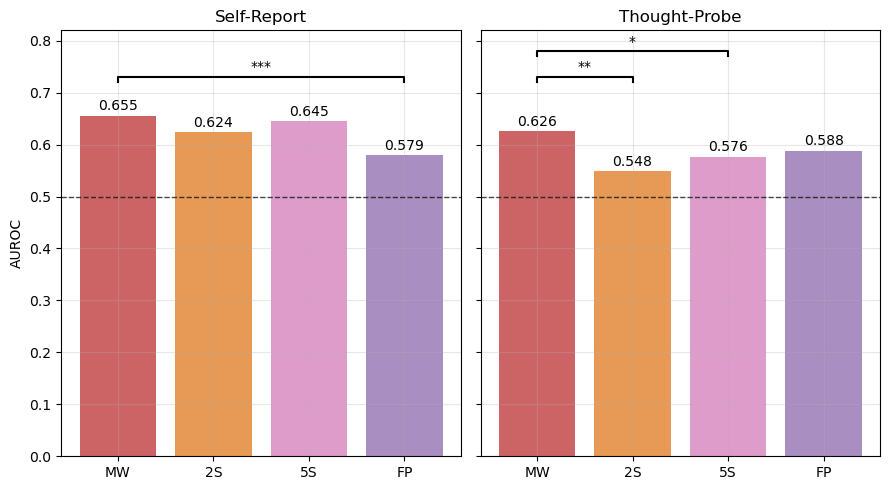

In [15]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns

# === Settings ===
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = 'comparison_permutation_test_results.csv'
df = pd.read_csv(os.path.join(path, file_name))

# === Function to draw significance bars ===
def draw_sig_bar(ax, x1, x2, y, pval):
    if pval < 0.001:
        sig = '***'
    elif pval < 0.01:
        sig = '**'
    elif pval < 0.05:
        sig = '*'
    else:
        return  # Don't draw anything if not significant

    ax.plot([x1, x1, x2, x2], [y, y+0.01, y+0.01, y], lw=1.5, c='black')
    ax.text((x1 + x2) / 2, y + 0.015, sig, ha='center', va='bottom', fontsize=10)

# === Plot ===
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=True)
# Custom colors for the bars
custom_colors = ['tab:red', 'tab:orange', 'tab:pink', 'tab:purple']
labels = ['MW', '2S', '5S', 'FP']

# === Self-report (SR) ===
ax = axes[0]
df_sr = df[df['task_type'] == 'sr']
mw = df_sr['df1_auroc'].iloc[0]
end2 = df_sr[df_sr['win_type'] == 'end2']['df2_auroc'].iloc[0]
end5 = df_sr[df_sr['win_type'] == 'end5']['df2_auroc'].iloc[0]
page = df_sr[df_sr['win_type'] == 'page_fixed']['df2_auroc'].iloc[0]
scores = [mw, end2, end5, page]

sns.barplot(x=labels, y=scores, ax=ax, palette=custom_colors, alpha=0.8)
ax.set_title('Self-Report')
ax.set_ylabel('AUROC')
ax.set_ylim(0, 0.82)

# Add grid and horizontal line at 0.5
ax.grid(True, alpha=0.3)
ax.axhline(y=0.5, color='black', linestyle='--', alpha=0.7, linewidth=1)

for i, val in enumerate(scores):
    ax.text(i, val + 0.005, f"{val:.3f}", ha='center', va='bottom', fontsize=10)

# Significance bars for SR
# pval_2 = df_sr[df_sr['win_type'] == 'end2']['p_value'].iloc[0]
# draw_sig_bar(ax, 0, 1, 0.85, pval_2)

# pval_5 = df_sr[df_sr['win_type'] == 'end5']['p_value'].iloc[0]
# draw_sig_bar(ax, 0, 2, 0.9, pval_5)

pval_fp = df_sr[df_sr['win_type'] == 'page_fixed']['p_value'].iloc[0]
draw_sig_bar(ax, 0, 3, 0.72, pval_fp)

# === Thought-probe (TP) ===
ax = axes[1]
df_tp = df[df['task_type'] == 'tp']
mw = df_tp['df1_auroc'].iloc[0]
end2 = df_tp[df_tp['win_type'] == 'end2']['df2_auroc'].iloc[0]
end5 = df_tp[df_tp['win_type'] == 'end5']['df2_auroc'].iloc[0]
page = df_tp[df_tp['win_type'] == 'page_fixed']['df2_auroc'].iloc[0]
scores = [mw, end2, end5, page]

sns.barplot(x=labels, y=scores, ax=ax, palette=custom_colors, alpha=0.8)
ax.set_title('Thought-Probe')
ax.set_ylim(0, 0.82)

# Add grid and horizontal line at 0.5
ax.grid(True, alpha=0.3)
ax.axhline(y=0.5, color='black', linestyle='--', alpha=0.7, linewidth=1)

for i, val in enumerate(scores):
    ax.text(i, val + 0.005, f"{val:.3f}", ha='center', va='bottom', fontsize=10)

# Significance bars for TP
pval_2 = df_tp[df_tp['win_type'] == 'end2']['p_value'].iloc[0]
draw_sig_bar(ax, 0, 1, 0.72, pval_2)

pval_5 = df_tp[df_tp['win_type'] == 'end5']['p_value'].iloc[0]
draw_sig_bar(ax, 0, 2, 0.77, pval_5)

# pval_fp = df_tp[df_tp['win_type'] == 'page_fixed']['p_value'].iloc[0]
# draw_sig_bar(ax, 0, 3, 0.95, pval_fp)

plt.tight_layout()
plt.show()



## Feature importance

### Feature inspection

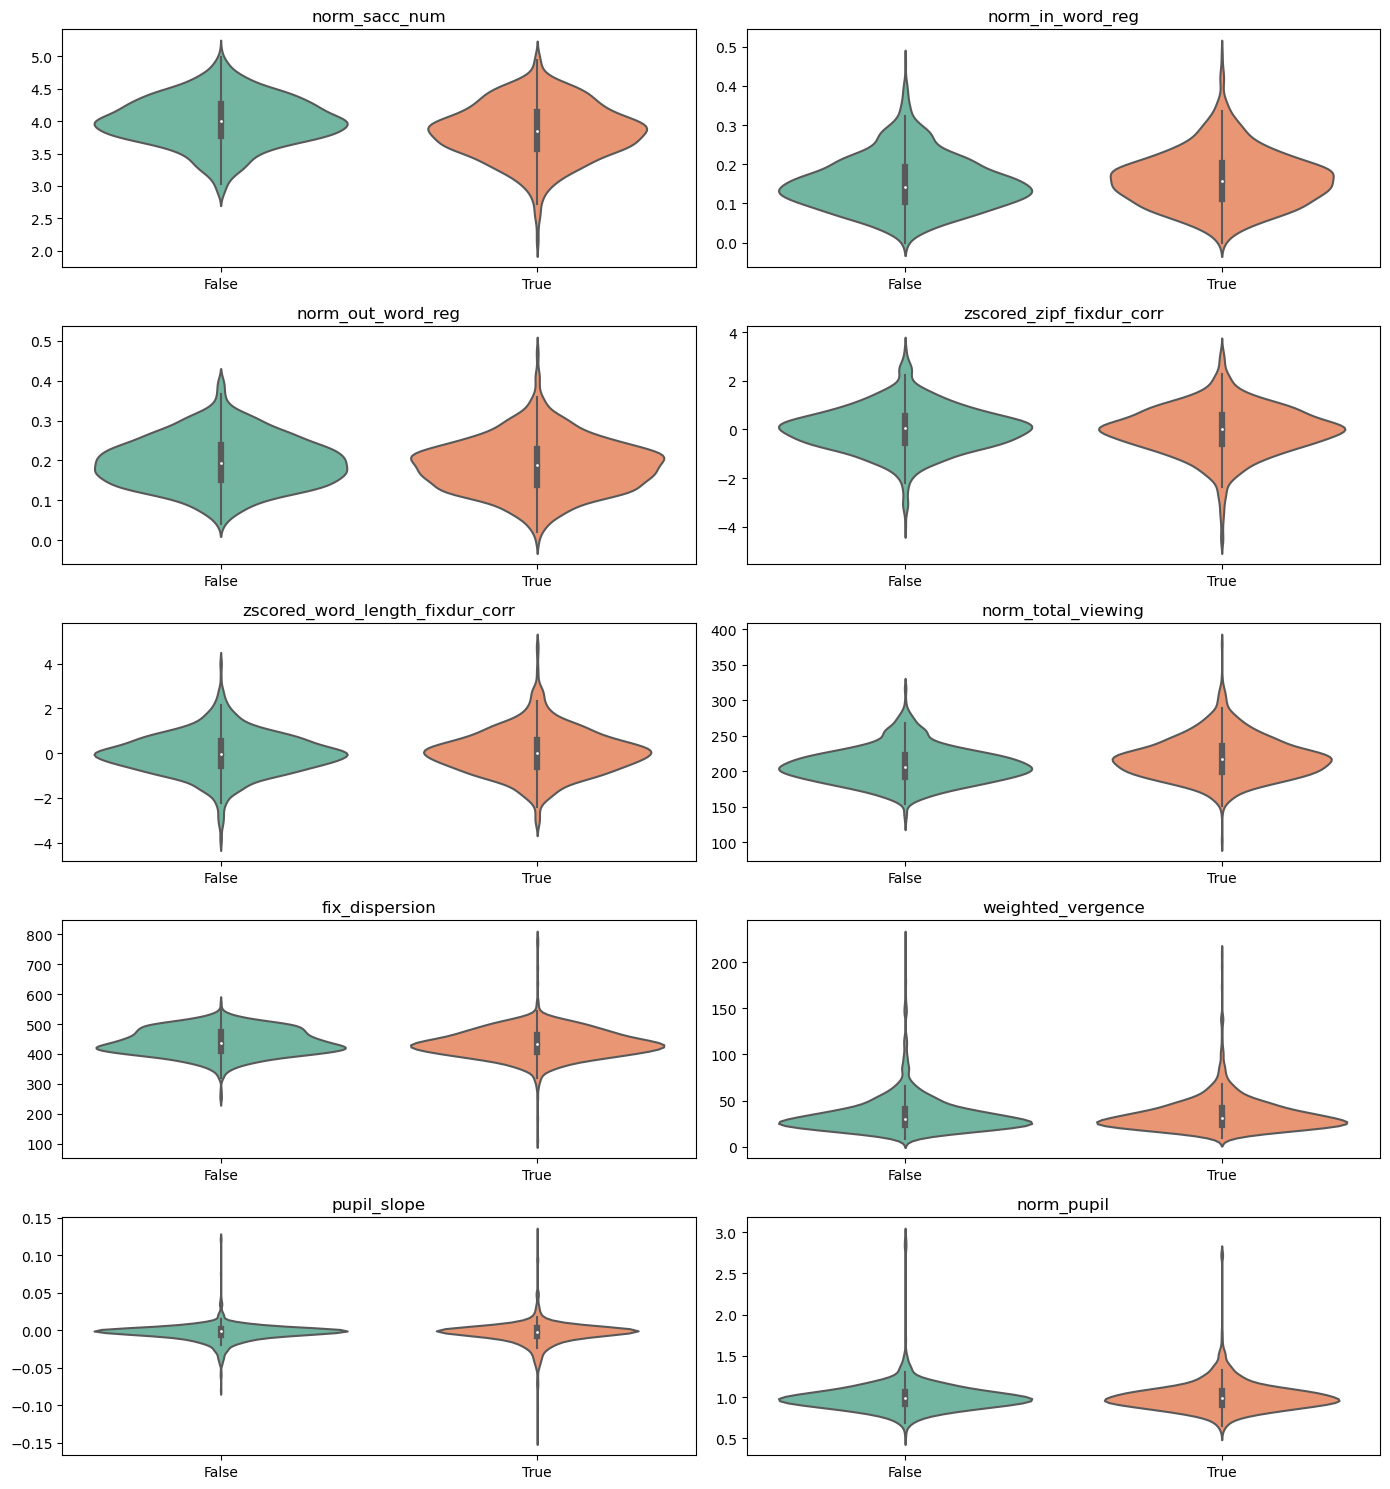

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = "group_features_page_fixed_sr.csv"
file_path = os.path.join(path, file_name)
df = pd.read_csv(file_path)
df = df[df['win_dur']>=5]

features = [
    "norm_sacc_num", "norm_in_word_reg", "norm_out_word_reg",
    "zscored_zipf_fixdur_corr", "zscored_word_length_fixdur_corr",
    "norm_total_viewing", 'fix_dispersion', 
    'weighted_vergence', "pupil_slope", "norm_pupil"
]

# Plot
n = len(features)
fig, axes = plt.subplots(nrows=(n + 1) // 2, ncols=2, figsize=(14, 3 * ((n + 1) // 2)))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    sns.violinplot(data=df, x='is_MWreported', y=feature, inner='box', ax=ax)
    ax.set_title(feature)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

### Feature importance plot

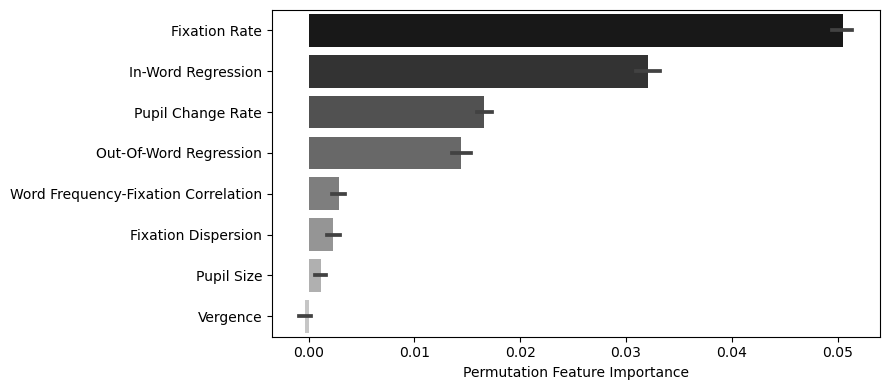

In [ ]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns

path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = "mw_fixed_feature_importance.csv"
df = pd.read_csv(os.path.join(path, file_name))

# Keep only permutation metric
df = df[df['metric'] == 'permutation']
df = df.rename(columns=feature_rename)

# Melt for seaborn
df_long = df.drop(columns=['metric']).melt(var_name='Feature', value_name='Importance')

# Sort by average importance
order = df_long.groupby('Feature')['Importance'].mean().sort_values(ascending=False).index

# Plot
plt.figure(figsize=(9, 4))
# Create a grayscale palette (light to dark)
gray_palette = sns.color_palette("Greys", n_colors=len(order)+3)[::-1]
gray_palette = gray_palette[:len(order)]
sns.barplot(data=df_long, x='Importance', y='Feature', order=order, palette=gray_palette)
plt.xlabel("Permutation Feature Importance")
plt.ylabel("")
plt.tight_layout()
# plt.savefig('feat_importance.png')
plt.show()


### eli5 feature importance table

In [182]:
import eli5
from eli5.sklearn import PermutationImportance
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.inspection import permutation_importance
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline

# Load dataset
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = "group_features_mw_fixed_sr.csv"
file_path = os.path.join(path, file_name)
df = pd.read_csv(file_path)
df = df[df['win_dur']>=5]

# Define features
features = [
        "norm_sacc_num", "norm_in_word_reg", "norm_out_word_reg",
        "zscored_zipf_fixdur_corr", "zscored_word_length_fixdur_corr",
        "norm_total_viewing", 'fix_dispersion', 
        'weighted_vergence', "pupil_slope", "norm_pupil"
    ]

df["label"] = df["is_MWreported"]
data = df.dropna(subset=features)

# Extract features, labels, and subject IDs
X = data[features].values
y = data["label"].values

model = Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression())  # Default parameters
    ])

model.fit(X, y)

perm = PermutationImportance(model).fit(X, y)
eli5.show_weights(perm, feature_names = features)


Weight,Feature
0.0316 ± 0.0141,norm_sacc_num
0.0240 ± 0.0055,pupil_slope
0.0149 ± 0.0087,norm_in_word_reg
0.0033 ± 0.0068,norm_out_word_reg
-0.0010 ± 0.0038,fix_dispersion
-0.0015 ± 0.0037,weighted_vergence
-0.0022 ± 0.0026,zscored_zipf_fixdur_corr
-0.0029 ± 0.0043,norm_total_viewing
-0.0049 ± 0.0025,zscored_word_length_fixdur_corr
-0.0055 ± 0.0055,norm_pupil


# Fig 5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Wilcoxon signed-rank test: statistic = 368.0000, p-value = 0.2093


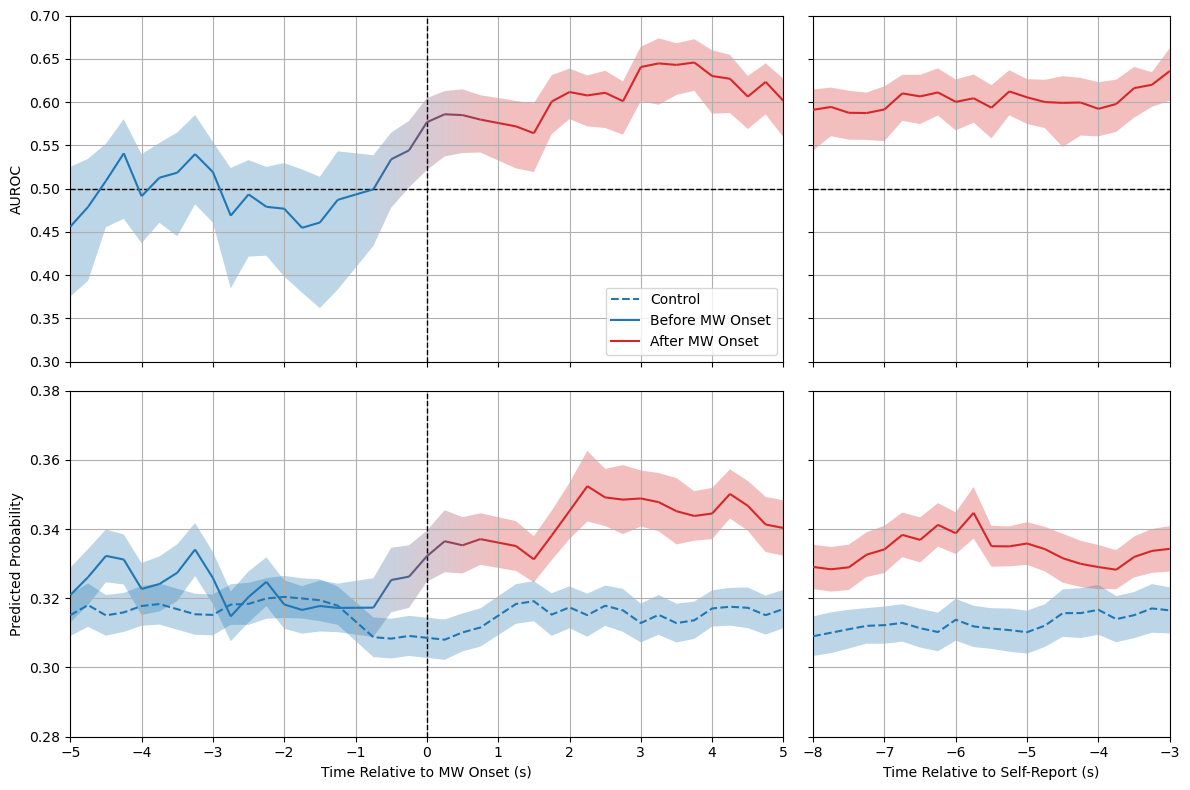

In [51]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from matplotlib.lines import Line2D

# === Load AUROC data ===
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
df = pd.read_csv(os.path.join(path, "deconding_acc_around_events.csv"))

df_real = df[df['iteration'] == 0].copy()
df_perm = df[df['iteration'] != 0].copy()
df_perm_ci = (
    df_perm
    .groupby(['condition', 'time'])['auroc']
    .quantile([0.025, 0.975])
    .unstack()
    .reset_index()
    .rename(columns={0.025: "ci_lower", 0.975: "ci_upper"})
)

wlen = 2
df_real.loc[np.abs(df_real['time']) == wlen / 2, 'auroc'] = np.nan
df_perm_ci.loc[np.abs(df_perm_ci['time']) == wlen / 2, ['ci_lower', 'ci_upper']] = np.nan

# === Plot AUROC and prediction probabilities ===
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1])

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)

# ---------------- AUROC plots ----------------
for i, (cond, ax) in enumerate(zip(['MW_onset', 'self_report'], [ax0, ax1])):
    df_ = df_real[df_real["condition"] == cond].copy()
    x = df_["time"]
    y = df_["auroc"].interpolate(method="linear", limit_direction="both")
    plot_gradient_line(ax, x, y, "tab:blue" if cond == 'MW_onset' else "tab:red", "tab:red", wlen)

    df_ci = df_perm_ci[df_perm_ci["condition"] == cond].copy()
    df_ci["ci_lower"] = df_ci["ci_lower"].interpolate(method="linear", limit_direction="both")
    df_ci["ci_upper"] = df_ci["ci_upper"].interpolate(method="linear", limit_direction="both")
    fill_between_gradient_imshow(ax, df_ci["time"], df_ci["ci_lower"], df_ci["ci_upper"],
                                 "tab:blue" if cond == 'MW_onset' else "tab:red", "tab:red", wlen)

    ax.axhline(0.5, color="black", linestyle="--", linewidth=1)
    # Top row: no x-labels
    ax.set_xlabel("")
    ax.set_xticks(range(int(x.min()), int(x.max()) + 1))
    ax.tick_params(labelbottom=False)
    ax.grid()
    ax.set_ylim(0.3, 0.7)
    if i == 0:
        ax.set_ylabel("AUROC")
        # Define custom legend handles
        legend_handles = [
            Line2D([0], [0], color='tab:blue', lw=1.5, linestyle='--', label='Control'),
            Line2D([0], [0], color='tab:blue', lw=1.5, label='Before MW Onset'),
            Line2D([0], [0], color='tab:red', lw=1.5, label='After MW Onset')
        ]
        # Add legend to the top-left subplot
        ax.legend(handles=legend_handles, loc="lower right", title="", fontsize=10)
        ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    else:
        ax.set_ylabel("")
        ax.legend().remove()
        plt.setp(ax.get_yticklabels(), visible=False)


# ---------------- Prediction probabilities ----------------
df = pd.read_csv(os.path.join(path, "pred_prob.csv"))
classifier_type = 'onset0'
df_ = df[df['classifier'] == classifier_type]

ax0 = fig.add_subplot(gs[1, 0])
ax1 = fig.add_subplot(gs[1, 1], sharey=ax0)
# ==================================================================================================
for i, (label_control, label_target, title, ax) in enumerate(zip(
    ['control_onset', 'control_sr'],
    ['MW_onset', 'self_report'],
    ['MW Onset', 'Self-Report'],
    [ax0, ax1]
)):
    df_ctrl = df_[df_['label'] == label_control]
    df_tgt = df_[df_['label'] == label_target]

    df_avg_ctrl = df_ctrl.groupby(['sub_id', 'time'])['pred_prob'].mean().reset_index()
    df_avg_tgt = df_tgt.groupby(['sub_id', 'time'])['pred_prob'].mean().reset_index()
    df_plot = df_avg_tgt.groupby('time')['pred_prob'].agg(['mean', 'sem']).reset_index()

    if label_target == 'MW_onset':
        # Filter for timepoints 0 and 5
        df_t0 = df_avg_tgt[df_avg_tgt['time'] == 0]
        df_t5 = df_avg_tgt[df_avg_tgt['time'] == 5]

        # Merge on sub_id to align paired samples
        df_paired = pd.merge(df_t0, df_t5, on='sub_id', suffixes=('_t0', '_t5'))

        # Perform Wilcoxon signed-rank test
        stat, p = wilcoxon(df_paired['pred_prob_t0'], df_paired['pred_prob_t5'])

        print(f"Wilcoxon signed-rank test: statistic = {stat:.4f}, p-value = {p:.4f}")

    # =======================================Control===========================================
    df_plot = df_avg_ctrl.groupby('time')['pred_prob'].agg(['mean', 'sem']).reset_index()
    df_plot.loc[np.abs(df_plot['time']) == wlen / 2, ['mean', 'sem']] = np.nan
    df_plot.loc[df_plot['time'] == 0, ['mean', 'sem']] = np.nan

    # Interpolate mean and std columns
    df_plot['mean'] = df_plot['mean'].interpolate(method='linear', limit_direction='both')
    df_plot['sem'] = df_plot['sem'].interpolate(method='linear', limit_direction='both')

    x = df_plot['time']
    y = df_plot['mean']
    y1, y2 = y - df_plot['sem'], y + df_plot['sem']
    start_color = 'tab:blue'
    end_color = 'tab:blue'
    fill_between_gradient_imshow(ax, x, y1, y2, start_color, end_color, wlen)
    plot_gradient_line(ax, x, y, start_color, end_color, wlen, linestyle='--')
    # =======================================Control===========================================

    # =======================================MW===========================================
    df_plot = df_avg_tgt.groupby('time')['pred_prob'].agg(['mean', 'sem']).reset_index()
    df_plot.loc[np.abs(df_plot['time']) == wlen / 2, ['mean', 'sem']] = np.nan

    # Interpolate mean and std columns
    df_plot['mean'] = df_plot['mean'].interpolate(method='linear', limit_direction='both')
    df_plot['sem'] = df_plot['sem'].interpolate(method='linear', limit_direction='both')

    x = df_plot['time']
    y = df_plot['mean']
    y1, y2 = y - df_plot['sem'], y + df_plot['sem']
    start_color = 'tab:blue' if title == 'MW Onset' else 'tab:red' 
    end_color = 'tab:red'
    fill_between_gradient_imshow(ax, x, y1, y2, start_color, end_color, wlen)
    plot_gradient_line(ax, x, y, start_color, end_color, wlen)
    # =======================================MW===========================================

    ax.set_xticks(range(int(x.min()), int(x.max()) + 1))
    ax.set_xlabel(f"Time Relative to {title} (s)")
    ax.grid()
    ax.legend().remove()
    ax.set_ylim(0.28, 0.38)
    if i == 0:
        ax.set_ylabel("Predicted Probability")
        ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    else:
        ax.set_ylabel("")
        plt.setp(ax.get_yticklabels(), visible=False)

# Final layout
plt.tight_layout()
plt.show()


## Classifier at each time point

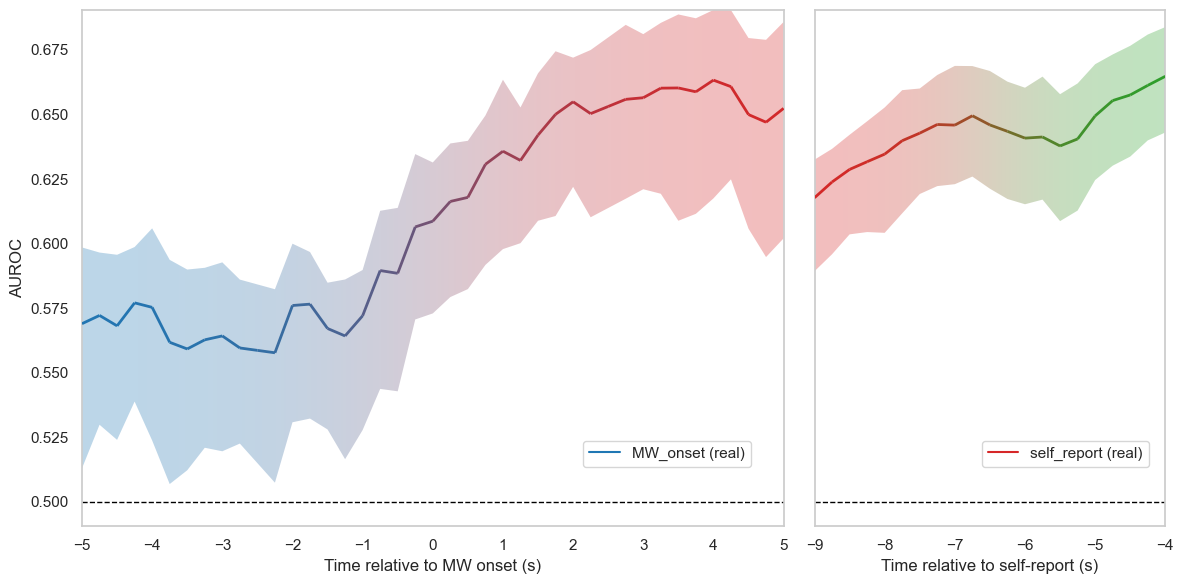

In [226]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, to_rgba
from matplotlib.patches import Polygon

def plot_gradient_line(ax, x, y, color_start, color_end, label=None, linewidth=2):
    x = np.asarray(x)
    y = pd.Series(y).interpolate(method='linear', limit_direction='both').to_numpy()

    valid_mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[valid_mask], y[valid_mask]

    if len(x) < 2:
        return

    sort_idx = np.argsort(x)
    x, y = x[sort_idx], y[sort_idx]

    # Nonlinear gradient for center emphasis
    center_weight = np.linspace(-1, 1, len(x))
    gradient_weights = 0.5 * (np.tanh(center_weight * 2) + 1)

    cmap = LinearSegmentedColormap.from_list("line_grad", [color_start, color_end])
    colors = cmap(gradient_weights)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, colors=colors[:-1], linewidth=linewidth, zorder=3)
    ax.add_collection(lc)

    if label:
        ax.plot([], [], color=color_start, label=label)

    ax.autoscale_view()

def fill_between_gradient_imshow(ax, x, y1, y2, color_start, color_end, alpha=0.3, resolution=300):
    import matplotlib.colors as mcolors

    x = np.asarray(x)
    y1 = pd.Series(y1).interpolate(method='linear', limit_direction='both').to_numpy()
    y2 = pd.Series(y2).interpolate(method='linear', limit_direction='both').to_numpy()

    valid = ~np.isnan(x) & ~np.isnan(y1) & ~np.isnan(y2)
    x, y1, y2 = x[valid], y1[valid], y2[valid]

    if len(x) < 2:
        return

    sort_idx = np.argsort(x)
    x, y1, y2 = x[sort_idx], y1[sort_idx], y2[sort_idx]

    xx = np.linspace(x.min(), x.max(), resolution)
    yy = np.linspace(min(y1.min(), y2.min()), max(y1.max(), y2.max()), resolution)

    # Same nonlinear center-based gradient
    center_weight = np.linspace(-1, 1, resolution)
    gradient = 0.5 * (np.tanh(center_weight * 2) + 1)  # sharper transition at center
    gradient = gradient.reshape(1, -1)
    gradient = np.repeat(gradient, resolution, axis=0)

    cmap = LinearSegmentedColormap.from_list("grad_fill", [color_start, color_end])
    extent = [x.min(), x.max(), yy.min(), yy.max()]
    ax.imshow(
        gradient,
        aspect='auto',
        extent=extent,
        origin='lower',
        cmap=cmap,
        alpha=alpha,
        zorder=1,
        interpolation='bicubic'
    )

    from matplotlib.path import Path
    from matplotlib.patches import PathPatch

    verts = np.column_stack([x, y1])
    verts = np.concatenate([verts, np.column_stack([x[::-1], y2[::-1]])])
    path = Path(verts)
    patch = PathPatch(path, facecolor='none', edgecolor='none', zorder=2)
    ax.add_patch(patch)

    for im in ax.get_images():
        im.set_clip_path(patch)

    ax.autoscale_view()

def fill_between_gradient(ax, x, y1, y2, color_start, color_end, alpha=0.9, steps=200):
    x = np.asarray(x)
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)

    # Ensure no NaNs
    valid_mask = ~np.isnan(x) & ~np.isnan(y1) & ~np.isnan(y2)
    x, y1, y2 = x[valid_mask], y1[valid_mask], y2[valid_mask]

    if len(x) < 2:
        return  # Nothing to draw

    # Sort by x to ensure segments are ordered
    sort_idx = np.argsort(x)
    x, y1, y2 = x[sort_idx], y1[sort_idx], y2[sort_idx]

    cmap = LinearSegmentedColormap.from_list("grad_fill", [color_start, color_end])

    x_range = np.linspace(x.min(), x.max(), steps + 1)

    for i in range(steps):
        x0, x1 = x_range[i], x_range[i + 1]
        mask = (x >= x0) & (x <= x1)

        if np.sum(mask) < 2:
            continue

        x_seg = x[mask]
        y1_seg = y1[mask]
        y2_seg = y2[mask]

        verts = np.column_stack([np.concatenate([x_seg, x_seg[::-1]]),
                                 np.concatenate([y1_seg, y2_seg[::-1]])])

        color = to_rgba(cmap(i / steps), alpha=alpha)
        poly = Polygon(verts, facecolor=color, edgecolor='none', zorder=1)
        ax.add_patch(poly)

    ax.autoscale_view()  # Ensure patches are within view


# load data
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = "deconding_acc_around_events.csv"
df = pd.read_csv(os.path.join(path, file_name))

df_real = df[df['iteration']==0].copy()
df_perm = df[df['iteration']!=0].copy()

# Compute CI
df_perm_ci = (
    df_perm
    .groupby(['condition', 'time'])['auroc']
    .quantile([0.025, 0.975])
    .unstack()
    .reset_index()
    .rename(columns={0.025: "ci_lower", 0.975: "ci_upper"})
)

# set time point at window center to be np.nan
wlen = 5
df_real.loc[np.abs(df_real['time'])==wlen/2, 'auroc'] = np.nan
df_perm_ci.loc[np.abs(df_perm_ci['time'])==wlen/2, ['ci_lower', 'ci_upper']] = np.nan

# fig = plt.figure(figsize=(12, 6))
# gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])   # first subplot is twice the size of the second

# conditions = ["MW_onset", "self_report"]
# colors = ["tab:red", "tab:green"]

# for idx, cond, color in zip([0, 1], conditions, colors):
#     ax = fig.add_subplot(gs[idx]) 
#     # real auroc over time points
#     df_ = df_real[df_real["condition"] == cond]
#     sns.lineplot(x=df_["time"], y=df_["auroc"], label=f"{cond} (real)", color=color, ax=ax)

#     df_ = df_perm_ci[df_perm_ci['condition'] == cond].copy()
#     # Interpolate NaNs for fill_between
#     df_["ci_lower"] = df_["ci_lower"].interpolate(method="linear", limit_direction="both")
#     df_["ci_upper"] = df_["ci_upper"].interpolate(method="linear", limit_direction="both")
#     ax.fill_between(df_["time"], df_["ci_lower"], df_["ci_upper"], color=color, alpha=0.2, label="95% CI")

#     ax.axhline(0.5, color='black', linestyle='--', linewidth=1)
    
#     ax.set_title(cond)
#     ax.set_xlabel("Time relative to event (s)")
#     ax.set_ylabel("AUROC")
#     ax.legend(loc="lower right", bbox_to_anchor=(0.97, 0.1))


# plt.tight_layout()
# plt.show()


# fig = plt.figure(figsize=(12, 6))
# gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])   # first subplot is twice the size of the second
# # Create the subplots using GridSpec and share the y-axis
# ax1 = fig.add_subplot(gs[0])
# ax2 = fig.add_subplot(gs[1], sharey=ax1)
# plt.setp(ax2.get_yticklabels(), visible=False)   # Smaller subplot

# # real auroc over time points
# cond = 'MW_onset'
# color = 'tab:red'
# df_ = df_real[df_real["condition"] == cond]
# sns.lineplot(x=df_["time"], y=df_["auroc"], label=f"{cond} (real)", color=color, ax=ax1)

# df_ = df_perm_ci[df_perm_ci['condition'] == cond].copy()
# # Interpolate NaNs for fill_between
# df_["ci_lower"] = df_["ci_lower"].interpolate(method="linear", limit_direction="both")
# df_["ci_upper"] = df_["ci_upper"].interpolate(method="linear", limit_direction="both")
# ax1.fill_between(df_["time"], df_["ci_lower"], df_["ci_upper"], color=color, alpha=0.2, label="95% CI")

# ax1.axhline(0.5, color='black', linestyle='--', linewidth=1)

# # ax1.set_title(cond)
# ax1.set_xlabel("Time relative to MW onset (s)")
# ax1.set_ylabel("AUROC")
# ax1.legend(loc="lower right", bbox_to_anchor=(0.964, 0.1))
# ax1.grid()
# # Set x-axis ticks to be 1 second intervals
# time_range = df_["time"].min(), df_["time"].max()
# ax1.set_xticks(range(int(time_range[0]), int(time_range[1]) + 1, 1))  # 1-second interval

# # real auroc over time points
# cond = 'self_report'
# # color = 'tab:green'
# df_ = df_real[df_real["condition"] == cond]
# sns.lineplot(x=df_["time"], y=df_["auroc"], label=f"{cond} (real)", color=color, ax=ax2)

# df_ = df_perm_ci[df_perm_ci['condition'] == cond].copy()
# # Interpolate NaNs for fill_between
# df_["ci_lower"] = df_["ci_lower"].interpolate(method="linear", limit_direction="both")
# df_["ci_upper"] = df_["ci_upper"].interpolate(method="linear", limit_direction="both")
# ax2.fill_between(df_["time"], df_["ci_lower"], df_["ci_upper"], color=color, alpha=0.2, label="95% CI")

# ax2.axhline(0.5, color='black', linestyle='--', linewidth=1)

# # ax2.set_title(cond)
# ax2.set_xlabel("Time relative to self-report (s)")
# ax2.legend(loc="lower right", bbox_to_anchor=(0.975, 0.1))
# ax2.grid()

# # Adjust layout to avoid overlap
# plt.tight_layout()
# plt.show()



# Example plotting with AUROC
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

# -------------------- First subplot --------------------
cond = 'MW_onset'
df_ = df_real[df_real["condition"] == cond]
x = df_["time"]
y = df_["auroc"]
y = y.interpolate(method="linear", limit_direction="both")
plot_gradient_line(ax1, x, y, "tab:blue", "tab:red", label="MW_onset (real)")

df_ci = df_perm_ci[df_perm_ci["condition"] == cond].copy()
df_ci["ci_lower"] = df_ci["ci_lower"].interpolate(method="linear", limit_direction="both")
df_ci["ci_upper"] = df_ci["ci_upper"].interpolate(method="linear", limit_direction="both")
fill_between_gradient_imshow(
    ax1,
    df_ci["time"].values,
    df_ci["ci_lower"].values,
    df_ci["ci_upper"].values,
    "tab:blue",
    "tab:red",
    alpha=0.3
)

ax1.axhline(0.5, color="black", linestyle="--", linewidth=1)
ax1.set_xlabel("Time relative to MW onset (s)")
ax1.set_ylabel("AUROC")
ax1.set_xticks(range(int(x.min()), int(x.max()) + 1))
ax1.legend(loc="lower right", bbox_to_anchor=(0.964, 0.1))
ax1.grid()

# -------------------- Second subplot --------------------
cond = 'self_report'
df_ = df_real[df_real["condition"] == cond]
x = df_["time"]
y = df_["auroc"]
y = y.interpolate(method="linear", limit_direction="both")
plot_gradient_line(ax2, x, y, "tab:red", "tab:green", label="self_report (real)")

df_ci = df_perm_ci[df_perm_ci["condition"] == cond].copy()
df_ci["ci_lower"] = df_ci["ci_lower"].interpolate(method="linear", limit_direction="both")
df_ci["ci_upper"] = df_ci["ci_upper"].interpolate(method="linear", limit_direction="both")
fill_between_gradient_imshow(
    ax2,
    df_ci["time"].values,
    df_ci["ci_lower"].values,
    df_ci["ci_upper"].values,
    "tab:red",
    "tab:green",
    alpha=0.3
)

ax2.axhline(0.5, color="black", linestyle="--", linewidth=1)
ax2.set_xlabel("Time relative to self-report (s)")
ax2.set_xticks(range(int(x.min()), int(x.max()) + 1))
ax2.legend(loc="lower right", bbox_to_anchor=(0.975, 0.1))
ax2.grid()

plt.tight_layout()
plt.show()



## Predication probability at each time point

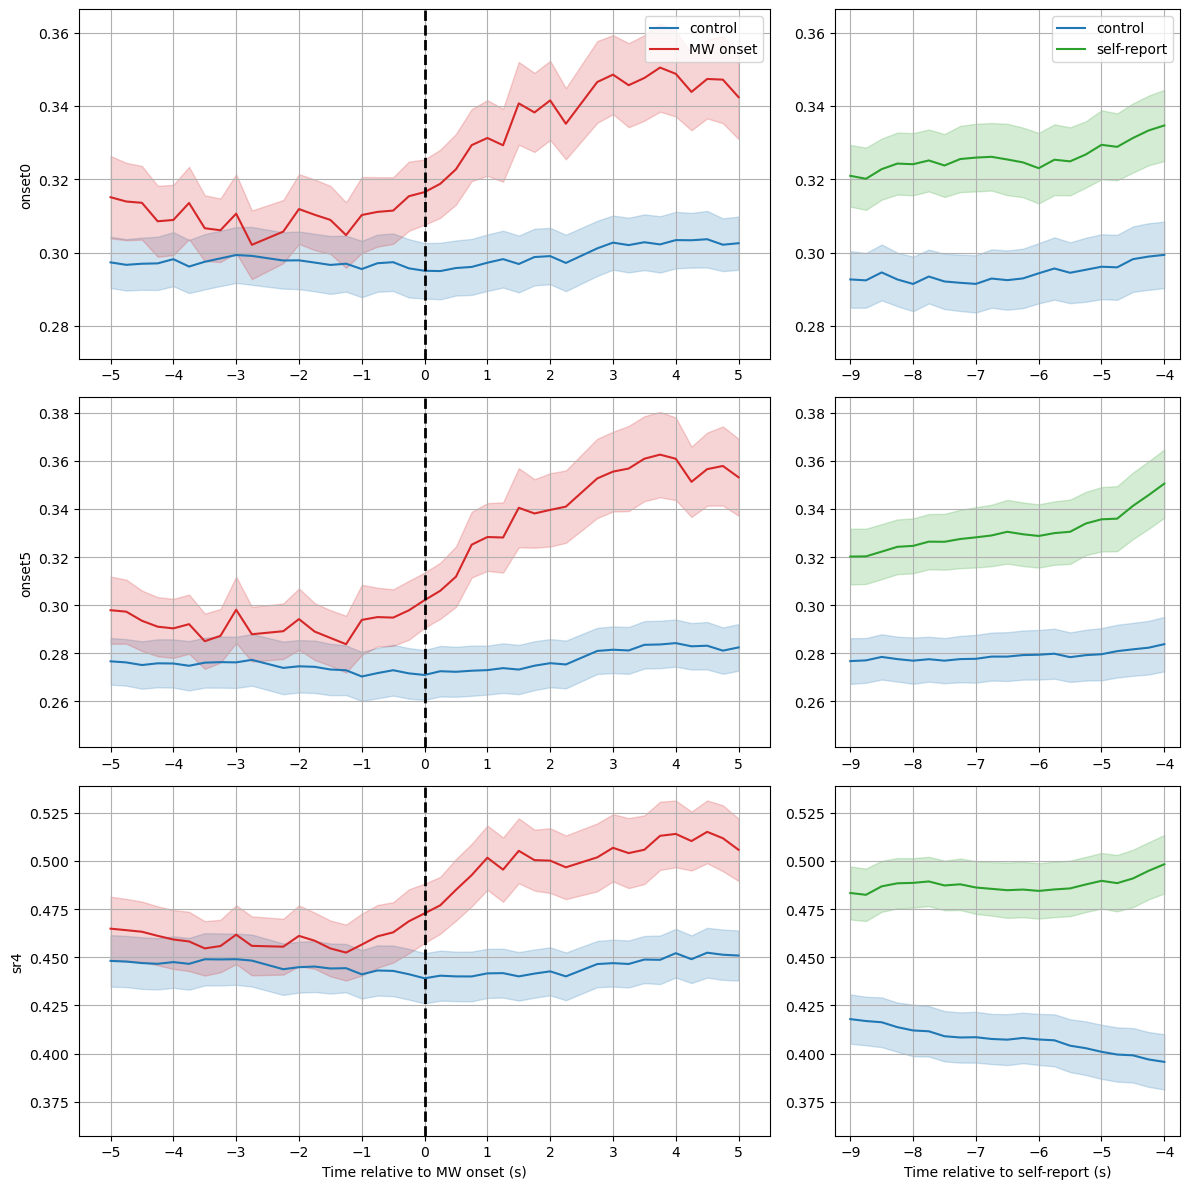

In [197]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from statannot import add_stat_annotation
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.gridspec import GridSpec

# GBLDriver path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = 'pred_prob.csv'

# load group file
df = pd.read_csv(os.path.join(path, file_name))
wlen = 5
types = ['onset0', 'onset5', 'sr4']


# Create the figure with a customized gridspec
fig = plt.figure(figsize=(12, 4 * len(types)))
gs = GridSpec(len(types), 2, width_ratios=[2, 1], figure=fig)  # column 0 is twice as wide

for i, type in enumerate(types):
    # Left plot (MW onset)
    ax0 = fig.add_subplot(gs[i, 0])
    # Right plot (Self-report)
    ax1 = fig.add_subplot(gs[i, 1], sharey=ax0)

    df_ = df[df['classifier']==type]

    for j, ax, label_control, label_target, color, title in zip(
        [0, 1],
        [ax0, ax1],
        ['control_onset', 'control_sr'],
        ['MW_onset', 'self_report'],
        ['tab:red', 'tab:green'],
        ['MW onset', 'self-report']
    ):
        df_control = df_[df_['label'] == label_control].copy()
        df_target = df_[df_['label'] == label_target].copy()

        df_avg_control = (
            df_control.groupby(['sub_id', 'time'])['pred_prob']
            .mean().reset_index()
        )
        df_avg_target = (
            df_target.groupby(['sub_id', 'time'])['pred_prob']
            .mean().reset_index()
        )

        # Remove edge values for smoothing
        for d in [df_avg_control, df_avg_target]:
            mask = abs(d['time']) == wlen / 2
            d.loc[mask, 'pred_prob'] = np.nan

        sns.lineplot(data=df_avg_control, x='time', y='pred_prob',
                     estimator='mean', errorbar='se', err_style='band',
                     color='tab:blue', label='control', ax=ax)
        sns.lineplot(data=df_avg_target, x='time', y='pred_prob',
                     estimator='mean', errorbar='se', err_style='band',
                     color=color, label=title, ax=ax)

        # ax.set_title(title)
        ax.grid()
        if i == 0:
            ax.legend()
        else:
            ax.legend().remove()

    # Consistent y-axis and significance bar
    ymins = [ax0.get_ylim()[0], ax1.get_ylim()[0]]
    ymaxs = [ax0.get_ylim()[1], ax1.get_ylim()[1]]
    ymin, ymax = min(ymins), max(ymaxs)
    offset = (ymax - ymin) * 0.05
    y_sig = ymin - offset
    for ax in [ax0, ax1]:
        ax.set_ylim(y_sig - offset, ymax)

    
    ax0.set_xticks(range(int(-5), int(5) + 1, 1))  # 1-second interval
    ax0.axvline(x=0, color='black', linestyle='--', linewidth=2)
    # Y-label only on left
    ax0.set_ylabel(type)
    ax1.set_ylabel("")
    # ax1.set_yticklabels([])

    # X-label only on bottom row
    if i == len(types) - 1:
        ax0.set_xlabel("Time relative to MW onset (s)")
        ax1.set_xlabel("Time relative to self-report (s)")
    else:
        ax0.set_xlabel("")
        # Turn off tick labels (numbers)
        # ax0.set_xticklabels([])
        # ax1.set_xticklabels([])
        ax1.set_xlabel("")

# Hide the middle spacer column
for i in range(len(features)):
    fig.add_subplot(gs[i, 1]).axis('off')

plt.tight_layout()
plt.show()



    

## Feature importance

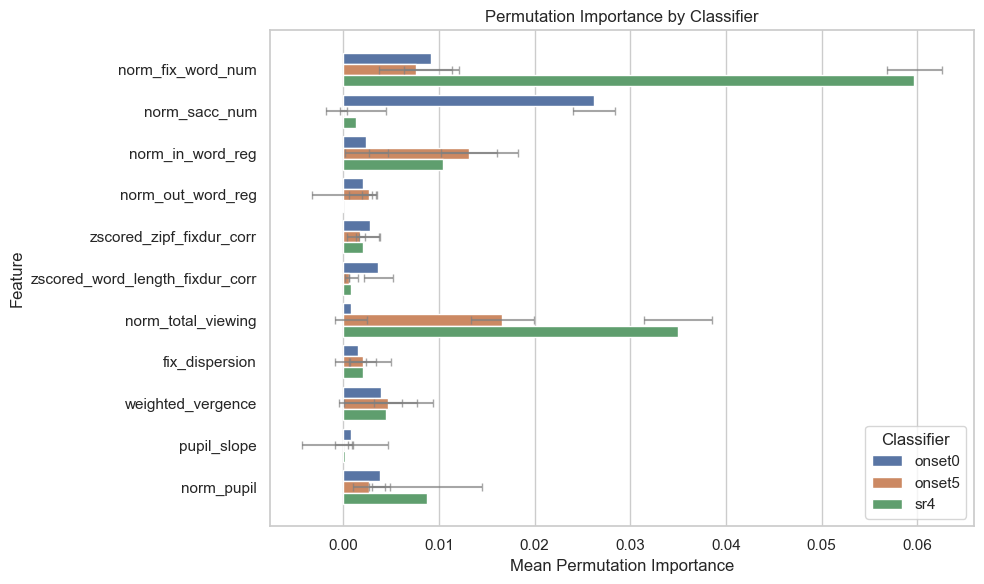

In [200]:
import pandas as pd
import os
from matplotlib import pyplot as plt

path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = 'feature_importance_slidingwindow.csv'
df = pd.read_csv(os.path.join(path, file_name))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot with error bars using seaborn
ax = sns.barplot(
    data=df,
    x="mean_importance",
    y="feature",
    hue="classifier",
    orient="h",
    errorbar=None
)

# Manually add error bars
for i, row in df.iterrows():
    ax.errorbar(
        x=row["mean_importance"],
        y=i % len(df["feature"].unique()),  # repeats per classifier
        xerr=row["std_importance"],
        fmt='none',
        ecolor='gray',
        capsize=3,
        alpha=0.7
    )

plt.xlabel("Mean Permutation Importance")
plt.ylabel("Feature")
plt.title("Permutation Importance by Classifier")
plt.legend(title="Classifier")
plt.tight_layout()
plt.show()

# Supplementary Figs

## Time histogram

### MW Offset <--> Self-Report


== MW Offset to Self-Report ==
Mean: 3.149414985590793
Median: 2.0560000000004948
Std Dev: 4.165218805399305


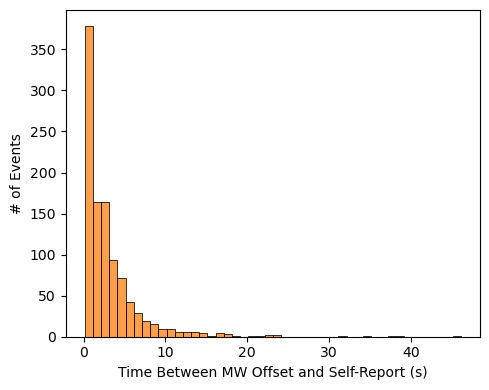

In [12]:
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# load eye feature file
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file = "reading_time_data.csv"
df = pd.read_csv(os.path.join(path, file))

# Stats for MW duration
print("\n== MW Offset to Self-Report ==")
print("Mean:", df['offset2page_end'].mean())
print("Median:", df['offset2page_end'].median())
print("Std Dev:", df['offset2page_end'].std())

# sns.set(style="whitegrid")
bin_width = 1
bins = np.arange(df['offset2page_end'].min(), df['offset2page_end'].max() + bin_width, bin_width)

plt.figure(figsize=(5, 4))
sns.histplot(data=df, x='offset2page_end', color='tab:orange', bins=bins)
plt.ylabel("# of Events")
plt.xlabel("Time Between MW Offset and Self-Report (s)")
plt.tight_layout()


### MW Duration (used for analysis)


== MW Onset to Page End (-alpha) ==
Mean: 9.134341487279837
Median: 6.505499999999984
Std Dev: 8.47325985242747


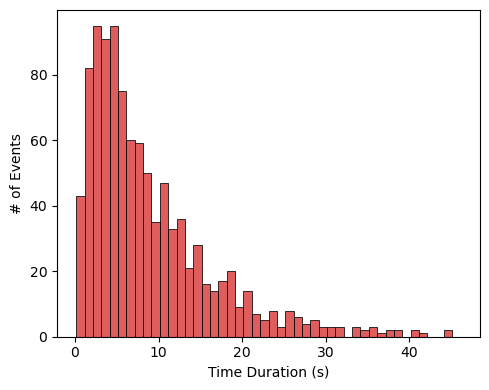

In [14]:
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# load eye feature file
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file = "reading_time_data.csv"
df = pd.read_csv(os.path.join(path, file))
alpha = 2
df['mw_dur_alpha'] = df['onset2page_end'] - alpha
df = df[df['mw_dur_alpha'] > 0]

# Stats for MW duration
print("\n== MW Onset to Page End (-alpha) ==")
print("Mean:", df['mw_dur_alpha'].mean())
print("Median:", df['mw_dur_alpha'].median())
print("Std Dev:", df['mw_dur_alpha'].std())

# sns.set(style="whitegrid")
# bin_width = 1
# bins = np.arange(df['mw_dur_alpha'].min(), df['mw_dur_alpha'].max() + bin_width, bin_width)

plt.figure(figsize=(5, 4))
sns.histplot(data=df, x='mw_dur_alpha', color='tab:red', bins=bins)
plt.ylabel("# of Events")
plt.xlabel("Time Duration (s)")
plt.tight_layout()


## Fix rate and pupil size near the EOP

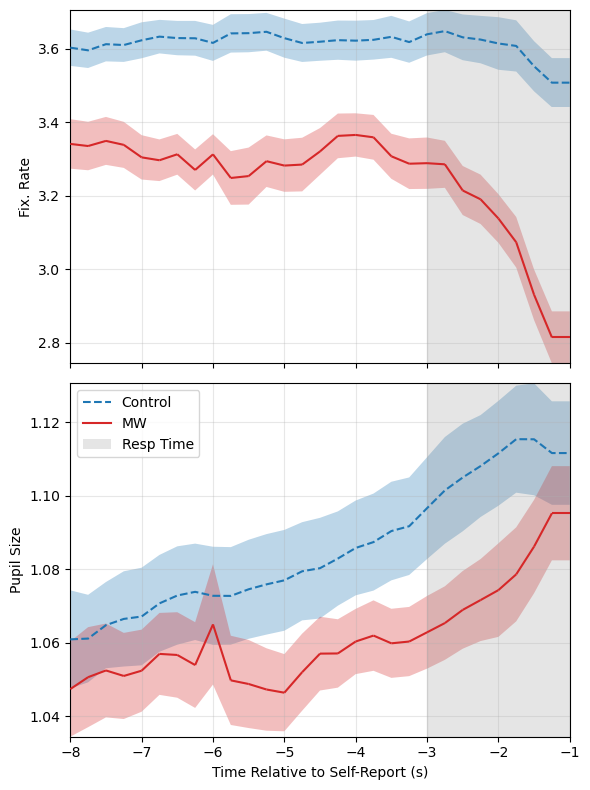

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# GBLDriver path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
wlen = 2.0
file_name = f'group_features_slide{wlen}.csv'

# Load group file
df = pd.read_csv(os.path.join(path, file_name))
mask = (df['label'] == 'self_report') & (df['win_start'] < df['mw_onset'])
df = df[~mask].copy()
df['relative_time'] = df['relative_time'].round(4)

# Define features and clean labels
features = ['norm_fix_word_num', 'norm_pupil']
y_labels = {
    'norm_fix_word_num': 'Fix. Rate',
    'norm_pupil': 'Pupil Size'
}

# Group by subject and time, then take mean
df_grouped = (
    df.groupby(['sub_id', 'label', 'relative_time'])[features]
    .mean()
    .reset_index()
)

# Split conditions
df_control = df_grouped[df_grouped['label'] == 'control_sr']
df_target = df_grouped[df_grouped['label'] == 'self_report']

# Plot
fig, axs = plt.subplots(len(features), 1, figsize=(8, 4 * len(features)), sharex=True)

for i, feature in enumerate(features):
    ax = axs[i]

    # =======================================Control===========================================
    df_avg_control = (
            df_control.groupby(['sub_id', 'relative_time'])[feature]
            .mean().reset_index()
        )
    # Aggregate mean and SEM
    df_plot = (
        df_avg_control
        .groupby('relative_time')[feature]
        .agg(mean='mean', sem='sem')
        .reset_index()
    )

    # Remove edge values for smoothing
    mask = abs(df_plot['relative_time']) == wlen / 2
    df_plot.loc[mask, ['mean', 'sem']] = np.nan
    # Interpolate mean and std columns
    df_plot['mean'] = df_plot['mean'].interpolate(method='linear', limit_direction='both')
    df_plot['sem'] = df_plot['sem'].interpolate(method='linear', limit_direction='both')

    # compute values to plot
    x = df_plot['relative_time'].values
    y = df_plot['mean'].values
    y1 = y - df_plot['sem'].values
    y2 = y + df_plot['sem'].values

    # Fill with gradient
    start_color = 'tab:blue'
    end_color = 'tab:blue'
    fill_between_gradient_imshow(ax, x, y1, y2, start_color, end_color, wlen, alpha=0.3)

    # Plot gradient line
    plot_gradient_line(ax, x, y, start_color, end_color, wlen, linestyle='--')
    # =======================================Control===========================================


    # =======================================MW===========================================
    df_avg_target = (
            df_target.groupby(['sub_id', 'relative_time'])[feature]
            .mean().reset_index()
        )
    # Aggregate mean and SEM
    df_plot = (
        df_avg_target
        .groupby('relative_time')[feature]
        .agg(mean='mean', sem='sem')
        .reset_index()
    )

    # Remove edge values for smoothing
    mask = abs(df_plot['relative_time']) == wlen / 2
    df_plot.loc[mask, ['mean', 'sem']] = np.nan
    # Interpolate mean and std columns
    df_plot['mean'] = df_plot['mean'].interpolate(method='linear', limit_direction='both')
    df_plot['sem'] = df_plot['sem'].interpolate(method='linear', limit_direction='both')

    # compute values to plot
    x = df_plot['relative_time'].values
    y = df_plot['mean'].values
    y1 = y - df_plot['sem'].values
    y2 = y + df_plot['sem'].values

    # Fill with gradient
    start_color = 'tab:red'
    end_color = 'tab:red'
    fill_between_gradient_imshow(ax, x, y1, y2, start_color, end_color, wlen, alpha=0.3)

    # Plot gradient line
    plot_gradient_line(ax, x, y, start_color, end_color, wlen)
    # =======================================MW===========================================

    # remove legend
    ax.grid()

    # Highlight region from x = -3 to -1
    ax.axvspan(-3, -1, color='gray', alpha=0.2)

    ax.set_ylabel(y_labels[feature])
    ax.grid(True, alpha=0.3)
    if i == len(features) - 1:
        legend_handles = [
            Line2D([0], [0], color='tab:blue', lw=1.5, linestyle='--', label='Control'),
            Line2D([0], [0], color='tab:red', lw=1.5, label='MW'),
            Patch(facecolor='gray', alpha=0.2, label='Resp Time')
        ]
        # Add legend to the top-left subplot
        ax.legend(handles=legend_handles, loc="upper left", title="", fontsize=10)
        ax.set_xlabel("Time Relative to Self-Report (s)")
    else:
        ax.set_xlabel("")

plt.tight_layout()
plt.show()


## Lineplot of all eye features

/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda3/envs/mindless_reading/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros.

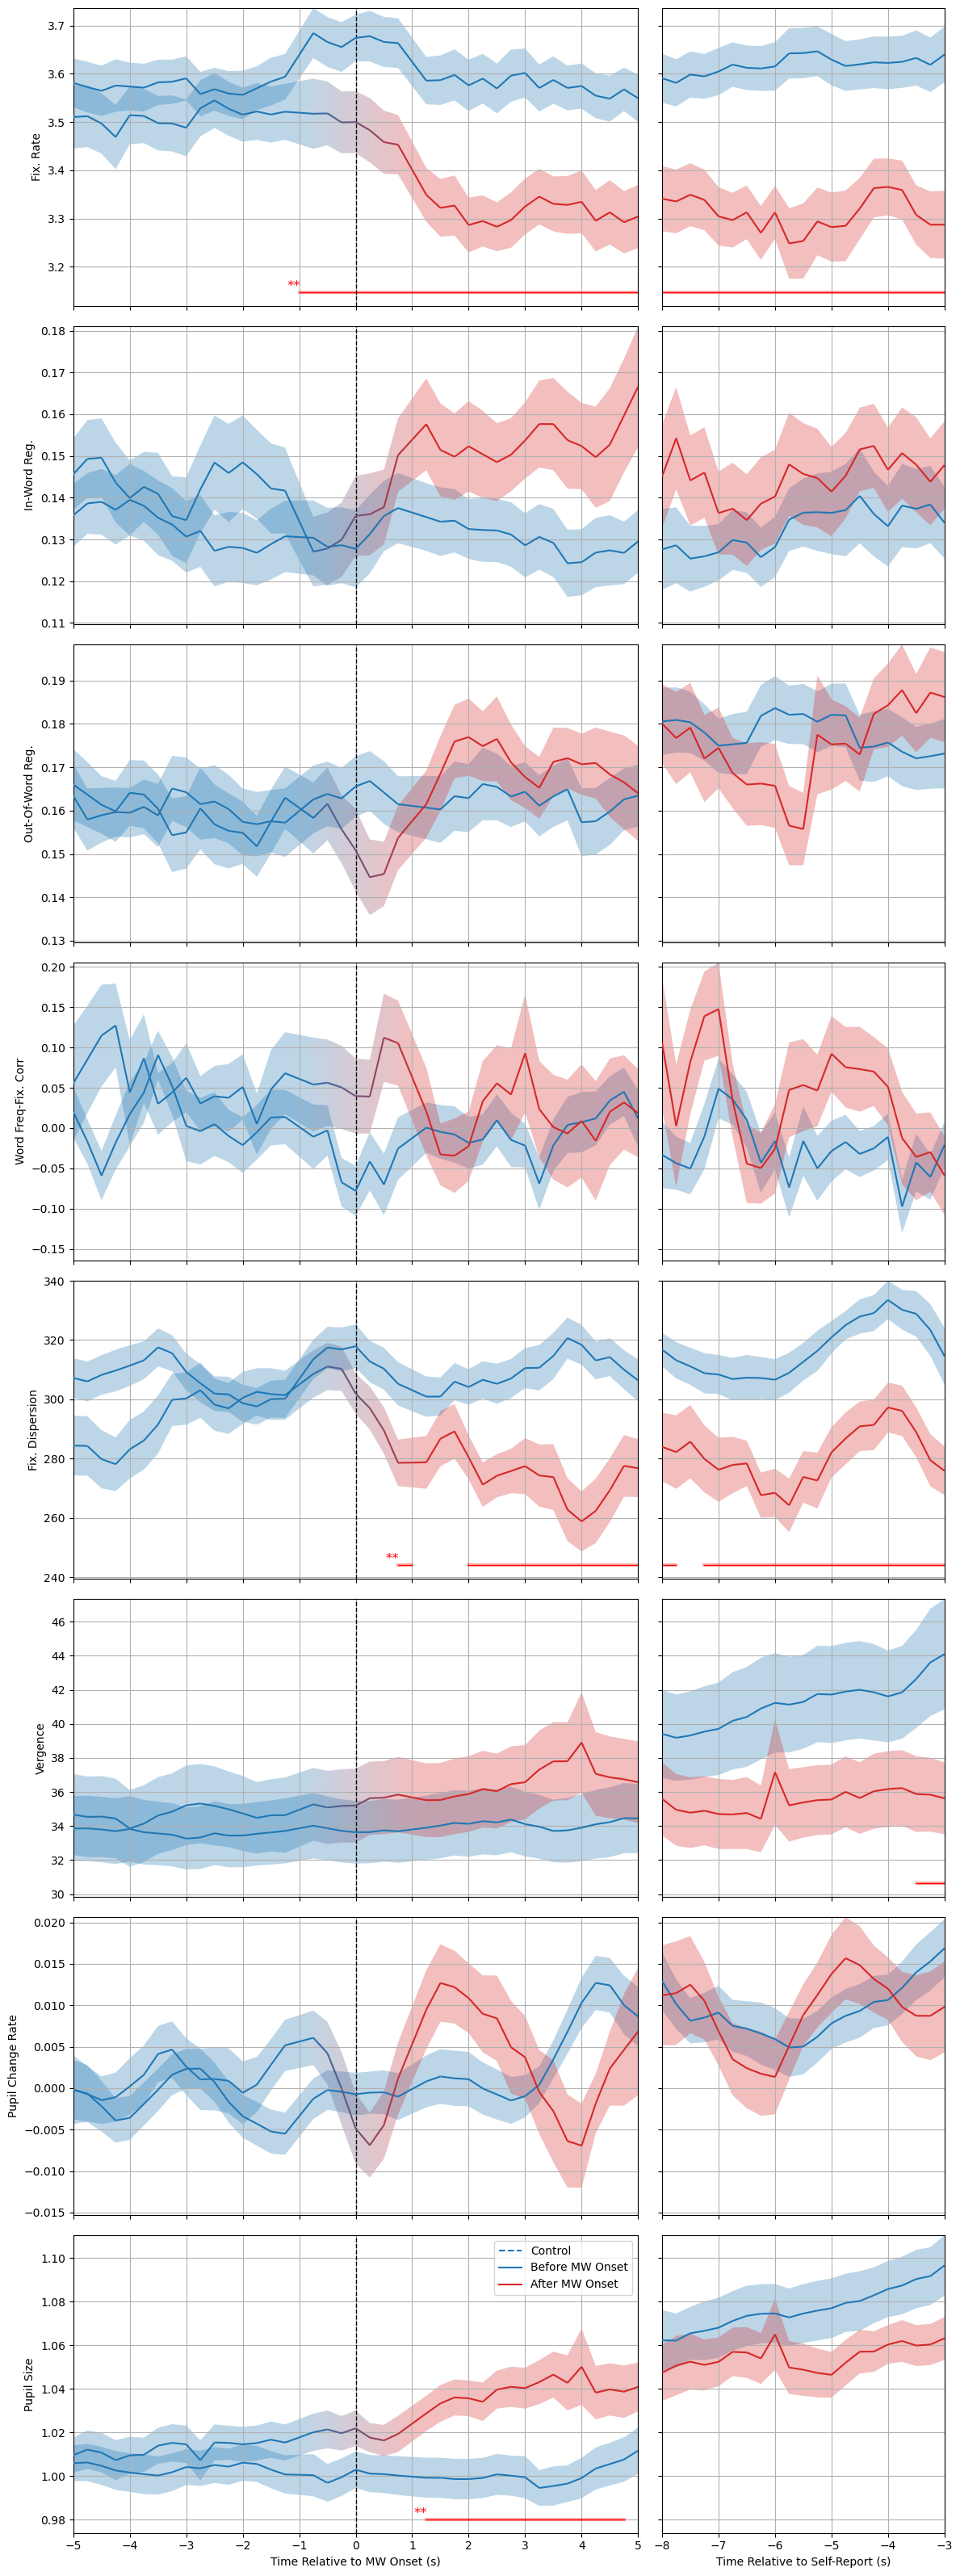

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

# GBLDriver path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
wlen = 2.0
# Slide Window (window duration 2 seconds)
file_name = f'group_features_slide{wlen}.csv'
# load group file
df = pd.read_csv(os.path.join(path, file_name))

# define the time offset (in seconds) to exclude
alpha = 2
mask = df['page_end']-df['win_end'] >= alpha
df = df[mask].copy()
# limit self-report to only MW discourse
mask = (df['label'] == 'self_report') & (df['win_start'] < df['mw_onset'])
df = df[~mask].copy()
df['relative_time'] = df['relative_time'].round(4)

# Rename features for readability
y_labels = feature_rename

# Create the figure with a customized gridspec
fig = plt.figure(figsize=(12, 4 * len(features)))
gs = GridSpec(len(features), 2, width_ratios=[2, 1], figure=fig)  # column 0 is twice as wide

for i, feature in enumerate(features):
    # Left plot (MW onset)
    ax0 = fig.add_subplot(gs[i, 0])
    # Right plot (Self-report)
    ax1 = fig.add_subplot(gs[i, 1], sharey=ax0)

    sig_blocks = [[], []]  # store blocks for both conditions (onset, self-report)

    for j, ax, label_control, label_target, color, title in zip(
        [0, 1],
        [ax0, ax1],
        ['control_onset', 'control_sr'],
        ['MW_onset', 'self_report'],
        ['tab:red', 'tab:green'],
        ['MW onset', 'self-report']
    ):
        df_control = df[df['label'] == label_control].copy()
        df_target = df[df['label'] == label_target].copy()

        df_avg_control = (
            df_control.groupby(['sub_id', 'relative_time'])[feature]
            .mean().reset_index()
        )
        df_avg_target = (
            df_target.groupby(['sub_id', 'relative_time'])[feature]
            .mean().reset_index()
        )

        # Merge to keep only matching (sub_id, relative_time) pairs
        matched_trials = pd.merge(
            df_avg_control,
            df_avg_target,
            on=['sub_id', 'relative_time'],
            suffixes=('_control', '_target')
        )

        # Split back into aligned DataFrames (optional, if needed)
        df_avg_control_matched = matched_trials[['sub_id', 'relative_time', f'{feature}_control']]
        df_avg_target_matched = matched_trials[['sub_id', 'relative_time', f'{feature}_target']]

        # Optionally rename columns back to original for plotting
        df_avg_control = df_avg_control_matched.rename(columns={f'{feature}_control': feature})
        df_avg_target = df_avg_target_matched.rename(columns={f'{feature}_target': feature})

        # Statistical test
        timepoints = df_avg_control['relative_time'].unique()
        timepoints.sort()
        # store stats results
        p_values = []
        for t in timepoints:
            # Extract matching rows at time t
            control_vals = df_avg_control[df_avg_control['relative_time'] == t][[ 'sub_id', feature]]
            target_vals = df_avg_target[df_avg_target['relative_time'] == t][[ 'sub_id', feature]]

            # Merge by sub_id to ensure alignment
            merged = pd.merge(control_vals, target_vals, on='sub_id', suffixes=('_control', '_target'))

            # Drop any NaNs that might have occurred
            merged = merged.dropna()

            # Perform Wilcoxon signed-rank test on the paired differences
            if len(merged) > 0:
                stat, p = wilcoxon(merged[f'{feature}_target'], merged[f'{feature}_control'])
            else:
                p = np.nan  # or 1.0 if you prefer to treat empty pairs as non-significant

            p_values.append(p)
        
        _, p_corrected = fdrcorrection(p_values, alpha=0.01)
        sig_times = np.sort(np.array(timepoints)[np.array(p_corrected) < 0.01])

        # Group significant timepoints into blocks
        breaks = np.where(np.diff(sig_times) > 0.25)[0] + 1
        blocks = np.split(sig_times, breaks)
        sig_blocks[j] = blocks

        # =======================================Control===========================================
        # Aggregate mean and SEM
        df_plot = (
            df_avg_control
            .groupby('relative_time')[feature]
            .agg(mean='mean', sem='sem')
            .reset_index()
        )

        # Remove edge values for smoothing
        mask = abs(df_plot['relative_time']) == wlen / 2
        df_plot.loc[mask, ['mean', 'sem']] = np.nan
        # Interpolate mean and std columns
        df_plot['mean'] = df_plot['mean'].interpolate(method='linear', limit_direction='both')
        df_plot['sem'] = df_plot['sem'].interpolate(method='linear', limit_direction='both')

        # compute values to plot
        x = df_plot['relative_time'].values
        y = df_plot['mean'].values
        y1 = y - df_plot['sem'].values
        y2 = y + df_plot['sem'].values

        # Fill with gradient
        start_color = 'tab:blue'
        end_color = 'tab:blue'
        fill_between_gradient_imshow(ax, x, y1, y2, start_color, end_color, wlen, alpha=0.3)

        # Plot gradient line
        plot_gradient_line(ax, x, y, start_color, end_color, wlen, label=title)
        # =======================================Control===========================================


        # =======================================MW===========================================
        # Aggregate mean and SEM
        df_plot = (
            df_avg_target
            .groupby('relative_time')[feature]
            .agg(mean='mean', sem='sem')
            .reset_index()
        )

        # Remove edge values for smoothing
        mask = abs(df_plot['relative_time']) == wlen / 2
        df_plot.loc[mask, ['mean', 'sem']] = np.nan
        # Interpolate mean and std columns
        df_plot['mean'] = df_plot['mean'].interpolate(method='linear', limit_direction='both')
        df_plot['sem'] = df_plot['sem'].interpolate(method='linear', limit_direction='both')

        # compute values to plot
        x = df_plot['relative_time'].values
        y = df_plot['mean'].values
        y1 = y - df_plot['sem'].values
        y2 = y + df_plot['sem'].values

        # Fill with gradient
        start_color = 'tab:blue' if title == 'MW onset' else 'tab:red'
        end_color = 'tab:red'
        fill_between_gradient_imshow(ax, x, y1, y2, start_color, end_color, wlen, alpha=0.3)

        # Plot gradient line
        plot_gradient_line(ax, x, y, start_color, end_color, wlen, label=title)
        # =======================================MW===========================================

        # remove legend
        ax.grid()
        ax.legend().remove()

    # Consistent y-axis and significance bar
    ymins = [ax0.get_ylim()[0], ax1.get_ylim()[0]]
    ymaxs = [ax0.get_ylim()[1], ax1.get_ylim()[1]]
    ymin, ymax = min(ymins), max(ymaxs)
    offset = (ymax - ymin) * 0.05
    y_sig = ymin - offset
    for ax in [ax0, ax1]:
        ax.set_ylim(y_sig - offset, ymax)
        ax.grid(True)

    # add significance bars for both plots
    is_plotted = False
    for block in sig_blocks[0]:
        if len(block) > 1:
            ax0.plot([block[0], block[-1]], [y_sig, y_sig], color='red', linewidth=1)
            ax0.plot([block[0], block[-1]], [y_sig, y_sig], color='red', linewidth=3, alpha=0.3)
            if not is_plotted:
                ax0.text((block[0]-0.1), y_sig, '**', ha='center', va='bottom', fontsize=12, color='red')
                is_plotted = True
    
    is_plotted = False
    for block in sig_blocks[1]:
        if len(block) > 1:
            ax1.plot([block[0], block[-1]], [y_sig, y_sig], color='red', linewidth=1)
            ax1.plot([block[0], block[-1]], [y_sig, y_sig], color='red', linewidth=3, alpha=0.3)

    ax0.set_xticks(range(int(-5), int(5) + 1, 1))  # 1-second interval
    ax0.axvline(x=0, color='black', linestyle='--', linewidth=1)
    # Y-label only on left
    ax0.set_ylabel(y_labels.get(feature, feature))
    ax1.set_ylabel("")
    plt.setp(ax1.get_yticklabels(), visible=False)

    # X-label only on bottom row
    if i == len(features) - 1:
        ax0.set_xlabel("Time Relative to MW Onset (s)")
        ax1.set_xlabel("Time Relative to Self-Report (s)")
        # Define custom legend handles
        legend_handles = [
            Line2D([0], [0], color='tab:blue', lw=1.5, linestyle='--', label='Control'),
            Line2D([0], [0], color='tab:blue', lw=1.5, label='Before MW Onset'),
            Line2D([0], [0], color='tab:red', lw=1.5, label='After MW Onset')
        ]
        # Add legend to the top-left subplot
        ax0.legend(handles=legend_handles, loc="upper right", title="", fontsize=10)
    else:
        ax0.set_xlabel("")
        ax0.tick_params(labelbottom=False)
        ax1.set_xlabel("")
        ax1.tick_params(labelbottom=False)

# Hide the middle spacer column
for i in range(len(features)):
    fig.add_subplot(gs[i, 1]).axis('off')

plt.tight_layout()
plt.show()



    

## Fix rate and pupil size on different MW length

Quartile thresholds:
  Q1: 3.57, Q2: 6.53, Q3: 12.06


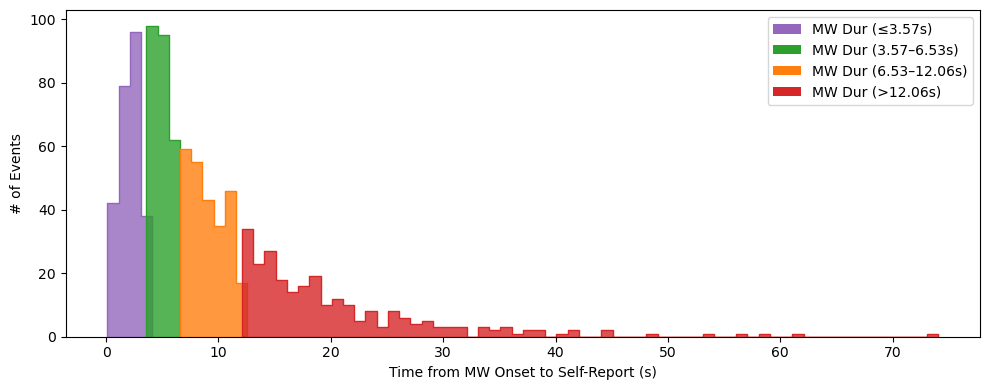

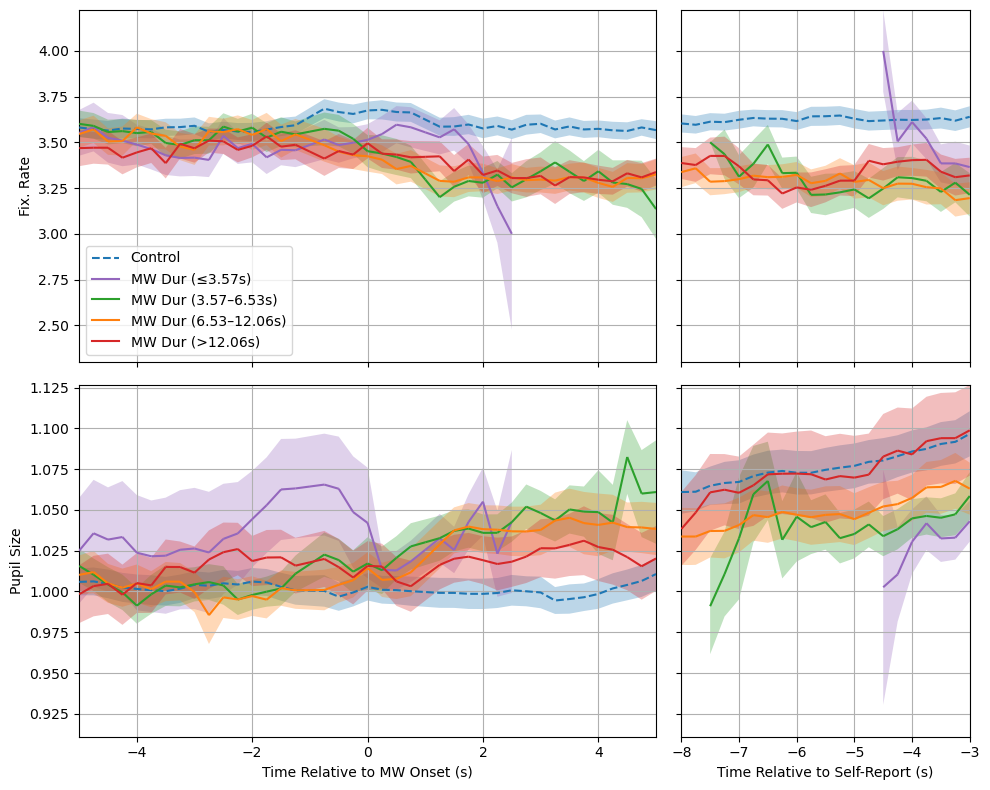

In [60]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# GBLDriver path
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
wlen = 2.0
# Slide Window (window duration 2 seconds)
file_name = f'group_features_slide{wlen}.csv'
# load group file
df = pd.read_csv(os.path.join(path, file_name))

# define the time offset (in seconds) to exclude
alpha = 2
mask = df['page_end']-df['win_end'] >= alpha
df = df[mask].copy()
# limit self-report to only MW discourse
mask = (df['label'] == 'self_report') & (df['win_start'] < df['mw_onset'])
df = df[~mask].copy()
df['relative_time'] = df['relative_time'].round(4)
df['mw_dur_alpha'] = df['page_end'] - df['mw_onset'] - alpha

# compute the histogram of trial length for MW onset
df_ = df[df['label'] == 'MW_onset'].drop_duplicates(subset=['sub_id', 'run', 'page'], keep='first')
dur = df_.loc[df_['mw_dur_alpha'] > 0, 'mw_dur_alpha']

# Get quartiles
q1, q2, q3 = dur.quantile([0.25, 0.5, 0.75])
print(f"Quartile thresholds:\n  Q1: {q1:.2f}, Q2: {q2:.2f}, Q3: {q3:.2f}")

# Define quartile colors and ranges
quartile_colors = {
    'Q1': 'tab:purple',
    'Q2': 'tab:green',
    'Q3': 'tab:orange',
    'Q4': 'tab:red'
}

quartile_bounds = {
    'Q1': (0, q1),
    'Q2': (q1, q2),
    'Q3': (q2, q3),
    'Q4': (q3, np.inf)
}

# Define readable labels with seconds
q1_label = f"MW Dur (≤{q1:.2f}s)"
q2_label = f"MW Dur ({q1:.2f}–{q2:.2f}s)"
q3_label = f"MW Dur ({q2:.2f}–{q3:.2f}s)"
q4_label = f"MW Dur (>{q3:.2f}s)"
qlabels = {'Q1': q1_label, 
            'Q2': q2_label, 
            'Q3': q3_label, 
            'Q4': q4_label}

segments = [
    dur[dur <= q1],
    dur[(dur > q1) & (dur <= q2)],
    dur[(dur > q2) & (dur <= q3)],
    dur[dur > q3]
]

# Plot histogram in quartile-colored segments
plt.figure(figsize=(10, 4))
for segment, (_, color) in zip(segments, quartile_colors.items()):
    sns.histplot(segment, binwidth=1, color=color, element='step', alpha=0.8)

legend_handles = [
            Patch(facecolor=quartile_colors[q], label=label)
            for q, label in qlabels.items()
        ]
        # Add legend to the top-left subplot
plt.legend(handles=legend_handles, loc="upper right", title="", fontsize=10)
plt.xlabel("Time from MW Onset to Self-Report (s)")
plt.ylabel("# of Events")
plt.tight_layout()
plt.show()

# define features to plot
features = ['norm_fix_word_num', 'norm_pupil']

# mapping feature names to clean y-axis labels
y_labels = {
    'norm_fix_word_num': 'Fix. Rate',
    'norm_pupil': 'Pupil Size'
}

# Create the figure with a customized gridspec
fig = plt.figure(figsize=(10, 4 * len(features)))
gs = GridSpec(len(features), 2, width_ratios=[2, 1], figure=fig)  # column 0 is twice as wide

for i, feature in enumerate(features):
    # Left plot (MW onset)
    ax0 = fig.add_subplot(gs[i, 0])
    # Right plot (Self-report)
    ax1 = fig.add_subplot(gs[i, 1], sharey=ax0)

    sig_blocks = [[], []]  # store blocks for both conditions (onset, self-report)

    p_dict = [{}, {}]

     # Plot each quartile
    for qlabel, (low, high) in quartile_bounds.items():
        df_q = df[
            (df['mw_dur_alpha'] > low) &
            (df['mw_dur_alpha'] <= high)
        ].copy()

        for j, ax, label_control, label_target in zip(
            [0, 1],
            [ax0, ax1],
            ['control_onset', 'control_sr'],
            ['MW_onset', 'self_report']
        ):
            df_control = df[df['label'] == label_control].copy()
            df_target = df_q[df_q['label'] == label_target].copy()

            # df_avg_control = df_control
            # df_avg_target = df_target

            df_avg_control = (
                df_control.groupby(['sub_id', 'relative_time'])[feature]
                .mean().reset_index()
            )
            df_avg_target = (
                df_target.groupby(['sub_id', 'relative_time'])[feature]
                .mean().reset_index()
            )

            # # Merge to keep only matching (sub_id, relative_time) pairs
            # matched_trials = pd.merge(
            #     df_avg_control,
            #     df_avg_target,
            #     on=['sub_id', 'relative_time'],
            #     suffixes=('_control', '_target')
            # )

            # # Split back into aligned DataFrames (optional, if needed)
            # df_avg_control_matched = matched_trials[['sub_id', 'relative_time', f'{feature}_control']]
            # df_avg_target_matched = matched_trials[['sub_id', 'relative_time', f'{feature}_target']]

            # # Optionally rename columns back to original for plotting
            # df_avg_control = df_avg_control_matched.rename(columns={f'{feature}_control': feature})
            # df_avg_target = df_avg_target_matched.rename(columns={f'{feature}_target': feature})

            # # Statistical test
            # timepoints = df_avg_control['relative_time'].unique()
            # timepoints.sort()
            # # store stats results
            # p_values = []
            # for t in timepoints:
            #     # Extract matching rows at time t
            #     control_vals = df_avg_control[df_avg_control['relative_time'] == t][[ 'sub_id', feature]]
            #     target_vals = df_avg_target[df_avg_target['relative_time'] == t][[ 'sub_id', feature]]

            #     # Merge by sub_id to ensure alignment
            #     merged = pd.merge(control_vals, target_vals, on='sub_id', suffixes=('_control', '_target'))

            #     # Drop any NaNs that might have occurred
            #     merged = merged.dropna()

            #     # Perform Wilcoxon signed-rank test on the paired differences
            #     if len(merged) > 0:
            #         stat, p = wilcoxon(merged[f'{feature}_target'], merged[f'{feature}_control'])
            #     else:
            #         p = np.nan  # or 1.0 if you prefer to treat empty pairs as non-significant

            #     p_values.append(p)
            
            # _, p_corrected = fdrcorrection(p_values, alpha=0.01)
            # # p_corrected = p_values
            # sig_times = np.sort(np.array(timepoints)[np.array(p_corrected) < 0.01])

            # # Group significant timepoints into blocks
            # breaks = np.where(np.diff(sig_times) > 0.25)[0] + 1
            # blocks = np.split(sig_times, breaks)
            # sig_blocks[j] = blocks

            # p_dict[j][qlabel] = blocks

            if qlabel == "Q1":
                # =======================================Control===========================================
                # Aggregate mean and SEM
                df_plot = (
                    df_avg_control
                    .groupby('relative_time')[feature]
                    .agg(mean='mean', sem='sem')
                    .reset_index()
                )

                # Remove edge values for smoothing
                mask = abs(df_plot['relative_time']) == wlen / 2
                df_plot.loc[mask, ['mean', 'sem']] = np.nan
                # Interpolate mean and std columns
                df_plot['mean'] = df_plot['mean'].interpolate(method='linear', limit_direction='both')
                df_plot['sem'] = df_plot['sem'].interpolate(method='linear', limit_direction='both')

                # compute values to plot
                x = df_plot['relative_time'].values
                y = df_plot['mean'].values
                y1 = y - df_plot['sem'].values
                y2 = y + df_plot['sem'].values

                # Fill with gradient
                start_color = 'tab:blue'
                end_color = 'tab:blue'
                fill_between_gradient_imshow(ax, x, y1, y2, start_color, end_color, wlen, alpha=0.3)

                # Plot gradient line
                plot_gradient_line(ax, x, y, start_color, end_color, wlen, linestyle='--')
                # =======================================Control===========================================


            # =======================================MW===========================================
            # Aggregate mean and SEM
            df_plot = (
                df_avg_target
                .groupby('relative_time')[feature]
                .agg(mean='mean', sem='sem')
                .reset_index()
            )

            # Remove edge values for smoothing
            mask = abs(df_plot['relative_time']) == wlen / 2
            df_plot.loc[mask, ['mean', 'sem']] = np.nan
            # Interpolate mean and std columns
            df_plot['mean'] = df_plot['mean'].interpolate(method='linear', limit_direction='both')
            df_plot['sem'] = df_plot['sem'].interpolate(method='linear', limit_direction='both')

            # compute values to plot
            x = df_plot['relative_time'].values
            y = df_plot['mean'].values
            y1 = y - df_plot['sem'].values
            y2 = y + df_plot['sem'].values

            # Fill with gradient
            start_color = quartile_colors[qlabel]
            end_color = quartile_colors[qlabel]
            fill_between_gradient_imshow(ax, x, y1, y2, start_color, end_color, wlen, alpha=0.3)

            # Plot gradient line
            plot_gradient_line(ax, x, y, start_color, end_color, wlen)
            # =======================================MW===========================================

            # remove legend
            ax.grid()

    # Consistent y-axis and significance bar
    ymins = [ax0.get_ylim()[0], ax1.get_ylim()[0]]
    ymaxs = [ax0.get_ylim()[1], ax1.get_ylim()[1]]
    ymin, ymax = min(ymins), max(ymaxs)
    offset = (ymax - ymin) * 0.05
    y_sig = ymin - offset
    for ax in [ax0, ax1]:
        ax.set_ylim(y_sig - offset, ymax)
        ax.grid(True)

    # add significance bars for both plots
    # is_plotted = False
    # for block in sig_blocks[0]:
    #     if len(block) > 1:
    #         ax0.plot([block[0], block[-1]], [y_sig, y_sig], color='red', linewidth=1)
    #         ax0.plot([block[0], block[-1]], [y_sig, y_sig], color='red', linewidth=3, alpha=0.3)
    #         if not is_plotted:
    #             ax0.text((block[0]-0.1), y_sig, '**', ha='center', va='bottom', fontsize=12, color='red')
    #             is_plotted = True
    
    # is_plotted = False
    # for block in sig_blocks[1]:
    #     if len(block) > 1:
    #         ax1.plot([block[0], block[-1]], [y_sig, y_sig], color='red', linewidth=1)
    #         ax1.plot([block[0], block[-1]], [y_sig, y_sig], color='red', linewidth=3, alpha=0.3)

    # ax0.set_xticks(range(int(-5), int(5) + 1, 1))  # 1-second interval
    # ax0.axvline(x=0, color='black', linestyle='--', linewidth=1)
    # Y-label only on left
    ax0.set_ylabel(y_labels.get(feature, feature))
    ax1.set_ylabel("")
    plt.setp(ax1.get_yticklabels(), visible=False)

    # X-label only on bottom row
    if i == len(features) - 1:
        ax0.set_xlabel("Time Relative to MW Onset (s)")
        ax1.set_xlabel("Time Relative to Self-Report (s)")
    else:
        ax0.set_xlabel("")
        ax0.tick_params(labelbottom=False)
        ax1.set_xlabel("")
        ax1.tick_params(labelbottom=False)

        # Define custom legend handles
        legend_handles = [
            Line2D([0], [0], color=quartile_colors[q], lw=1.5, label=label)
            for q, label in qlabels.items()
        ]
        legend_handles = [Line2D([0], [0], color='tab:blue', lw=1.5, linestyle='--', label='Control')] + legend_handles
        # Add legend to the top-left subplot
        ax0.legend(handles=legend_handles, loc="lower left", title="", fontsize=10)

# Hide the middle spacer column
for i in range(len(features)):
    fig.add_subplot(gs[i, 1]).axis('off')

plt.tight_layout()
plt.show()


## Pupil size on page time

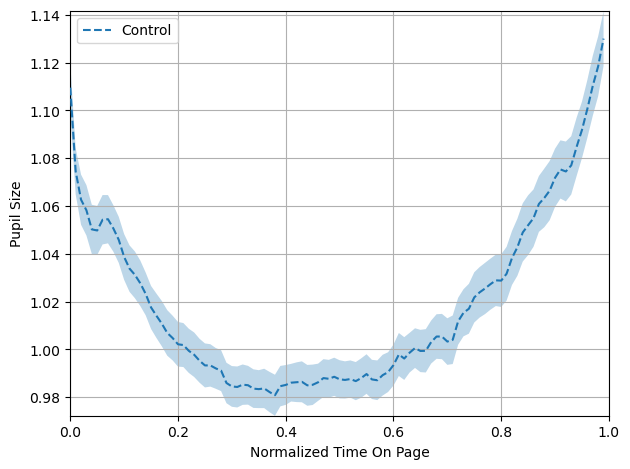

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# read data
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
df = pd.read_csv(os.path.join(path, 'pupil_size_on_page.csv'))
df_ = df[df['label']=='Non-MW']
wlen = 1
df_plot = (
    df_
    .groupby('tPage_bin')['RPupil']
    .agg(mean='mean', sem='sem')
    .reset_index()
)

# plot
fig, ax = plt.subplots() 
# compute values to plot
x = df_plot['tPage_bin'].values
y = df_plot['mean'].values
y1 = y - df_plot['sem'].values
y2 = y + df_plot['sem'].values

# Fill with gradient
start_color = 'tab:blue'
end_color = 'tab:blue'

fill_between_gradient_imshow(ax, x, y1, y2, start_color, end_color, wlen, alpha=0.3)
# Plot gradient line
plot_gradient_line(ax, x, y, start_color, end_color, wlen, linestyle='--')

# Define custom legend handles
legend_handles = [Line2D([0], [0], color='tab:blue', lw=1.5, linestyle='--', label='Control')]
# Add legend to the top-left subplot
ax.legend(handles=legend_handles, loc="best", title="", fontsize=10)

plt.grid()
plt.ylabel('Pupil Size')
plt.xlabel('Normalized Time On Page')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

## Individual MR ratio

Text(0, 0.5, '# of Participants')

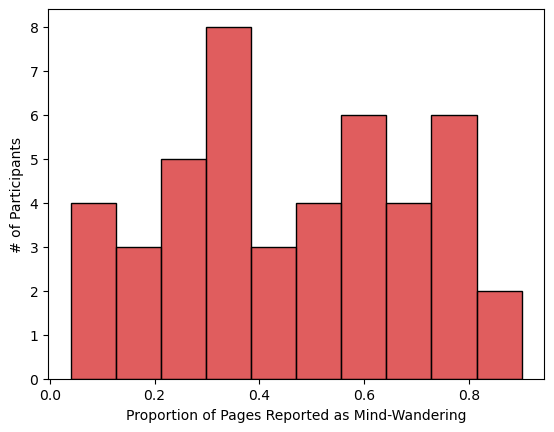

In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# load eye feature file
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file = "group_features_default_sr.csv"
df = pd.read_csv(os.path.join(path, file))

df_mw = df[df['is_MWreported']].copy()

sub_mw_ratio = []
total_pages = 50
for sub_id in df_mw['sub_id'].unique():
    # Fixed: Use sum() instead of length() to count True values
    mw_pages = (df_mw['sub_id'] == sub_id).sum()
    sub_mw_ratio.append(mw_pages/total_pages)

plt.figure()
# plt.grid()
sns.histplot(sub_mw_ratio, bins=10, color='tab:red')
plt.xlabel('Proportion of Pages Reported as Mind-Wandering')
plt.ylabel('# of Participants')